# Spectral method for a  Hugget model with two incomes

In [81]:
%run 'backend_v2022-06-10_1.ipynb'
backend_test_function()

Backend import successful! - 2022-08-06 18:36:36.611011


# Economic parameters

In [82]:
gamma = 1.2 # CRRA utility parameter
def u(x): return x**(1-gamma) / (1-gamma)
def du(x): return x**(-gamma)
def du_inv(x): return x**(-1/gamma)
rho = 0.05 # Discount rate

r = 0.035 # Interest rate

zlow, zhigh = 0.1, 0.2 # High, low income states
z = np.array([zlow, zhigh])

lambda1, lambda2 = 1.5, 1. # Low->high, high->low transition rates
G = np.array([[-lambda1, lambda1], [lambda2, -lambda2]]) # Generator / transition rate matrix

amin, amax = -0.02, 1 # Lower, upper asset constraint

## Numerical parameters

In [83]:
maxiter = 1000
crit = 1e-10

# Hamilton-Jacobi-Bellman Equation

## Finite differences

In [84]:
# Numerical parameters
I = 500
a_fd = np.linspace(amin, amax, I)
da_fd = (amax-amin)/(I-1)

aa_fd = np.tile(a_fd,(2,1))
zz_fd = np.tile(z,(I,1)).T

delta = 2000.

In [85]:
# Initial guess
v0_fd = u(r*aa_fd + zz_fd)/rho

# Transition matrix
z_transition = sparse.kron(G,sparse.eye(I), format='csr')

# Initialization
v_old = np.zeros((2,I))
g = np.zeros((2,I))
dv = np.zeros((2,I-1))
cf = np.zeros((2,I-1))
c0 = np.zeros((2,I))
ssf = np.zeros((2,I))
ssb = np.zeros((2,I))
is_backward = np.zeros((2,I))
is_forward = np.zeros((2,I))
diag_helper = np.zeros((2,I))        
A = z_transition.copy()
B = z_transition.copy()

In [86]:
v_fd = v0_fd.copy()

for i in range(maxiter):
            
    dv = (v_fd[:,1:]-v_fd[:,:-1])/da_fd
    cf = du_inv(dv)
    c0 = r*aa_fd + zz_fd
    
    ssf[:,:-1] = c0[:,:-1]-cf
    ssb[:,1:] = c0[:,1:]-cf

    is_backward = ssf>0
    is_forward = ssb<0
    
    c0[:,:-1] += (cf-c0[:,:-1])*is_backward[:,:-1]
    c0[:,1:] += (cf-c0[:,1:])*is_forward[:,1:]
    
    A = z_transition.copy()
    diag_helper = (-ssf*is_backward/da_fd + ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper,0,2*I,2*I)
    diag_helper = (-ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper[1:],-1,2*I,2*I)
    diag_helper = (ssf*is_backward/da_fd).flatten()
    A += sparse.spdiags(np.hstack((0,diag_helper)),1,2*I,2*I)
    
    B = sparse.eye(2*I)*(1/delta + rho) - A
    b = u(c0).reshape(-1,1) + v_fd.reshape(-1,1)/delta
    A_fd, v_old, s_fd = A.copy(), v_fd.copy(), (r*aa_fd + zz_fd - c0)
    v_fd = spsolve(B,b).reshape(2,I)

    dist = np.max(np.abs(v_old-v_fd))
    if dist < crit:
        print("Finished! - Loops:", i+1, "Dist:", dist)
        break
    elif i==maxiter-1: print("Failed to converge! - Loops:", i+1, "Dist:", dist)

Finished! - Loops: 13 Dist: 4.4707348934025504e-11


In [87]:
zz_fd, aa_fd = zz_fd.flatten(), aa_fd.flatten()
v_fd, s_fd = v_fd.flatten(), s_fd.flatten()

## Spectral method

In [88]:
N = 40

a_sp, [Da] = dm.chebdif(N, 1)
a_sp, [Da] = rescale_nodes_and_derivatives(a_sp, [Da], left=amin, right=amax)

aa_sp = np.tile(a_sp, 2)
zz_sp = np.repeat(z, N)

# Differentiation matrix w.r.t. a
D_a = np.kron(np.eye(2), Da)

# Switching matrix
GG = np.kron(G,np.eye(N))

# Initial guess
v0_sp = u(zz_sp+r*aa_sp)/rho

In [89]:
v_sp = v0_sp.copy()

for i in range(maxiter):
    
    delta = 0.01*np.exp(i)
    
    dv = D_a@v_sp
    c = du_inv(dv)
    s_sp = zz_sp + r*aa_sp - c
    
    A = s_sp.reshape(-1,1)*D_a + GG
    B = (1/delta + rho)*np.eye(2*N) - A
    b = u(c) + v_sp/delta
    
    B[0] = D_a[0]
    b[0] = du(zz_sp + r*aa_sp)[0]
    
    v_old = v_sp.copy()
    v_sp = np.linalg.solve(B,b)
    
    dist = np.max(np.abs(v_old-v_sp))
    if dist < crit:
        s_sp[np.abs(s_sp)<1e-10] = 0. # CCC
        v_sp, s_sp = v_sp.flatten(), s_sp.flatten()
        print("Finished! - Loops:", i+1, "Dist:", dist)
        break
    elif i==maxiter-1: print("Failed to converge! - Loops:", i+1, "Dist:", dist)

Finished! - Loops: 16 Dist: 1.4637180356658064e-11


## Output plots and boundary conditions

In [90]:
print("Boundary condition check (we want v'>=u'):")
print("u'(zlow+r*amin):", du(zlow+r*amin))
print("Sp: v'_low(amin):", (D_a@v_sp)[0])
print("u'(zhigh+r*amax):", du(zhigh+r*amax))
print("Sp: v'_high(amax):", (D_a@v_sp)[-1])

Boundary condition check (we want v'>=u'):
u'(zlow+r*amin): 15.983095772511849
Sp: v'_low(amin): 15.983095772535307
u'(zhigh+r*amax): 5.684844179713957
Sp: v'_high(amax): 5.40610634649056


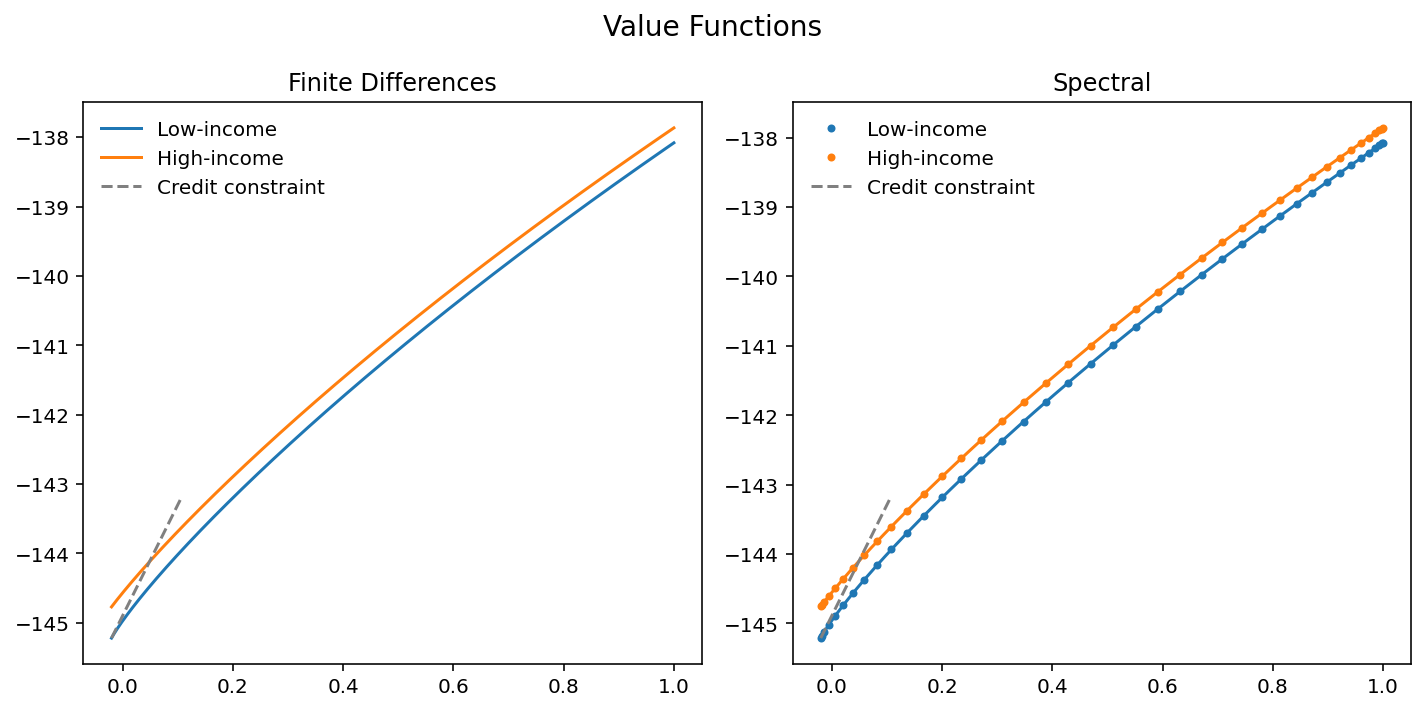

Saved to: two_state_value_function_finite_differences_vs_spectral.pdf


In [91]:
fd_bc_low = v_fd[0] + (a_fd-amin)*du(zlow+r*amin)
fd_sp_low = v_sp[0] + (a_fd-amin)*du(zlow+r*amin)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, v_fd[I:], 'C1', label='High-income')
ax[0].plot(a_fd[:I//8], fd_bc_low[:I//8], c='grey', ls='--', label='Credit constraint')
ax[0].legend(loc='upper left', frameon=False)
ax[0].set_title('Finite Differences')

ax[1].plot(a_sp, v_sp[:N], 'C0.', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd), 'C0')
ax[1].plot(a_sp, v_sp[N:], 'C1.', label='High-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd), 'C1')
ax[1].plot(a_fd[:I//8], fd_sp_low[:I//8], c='grey', ls='--', label='Credit constraint')
ax[1].set_title('Spectral')
ax[1].legend(loc='upper left', frameon=False)

fig.suptitle('Value Functions', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_function_finite_differences_vs_spectral')

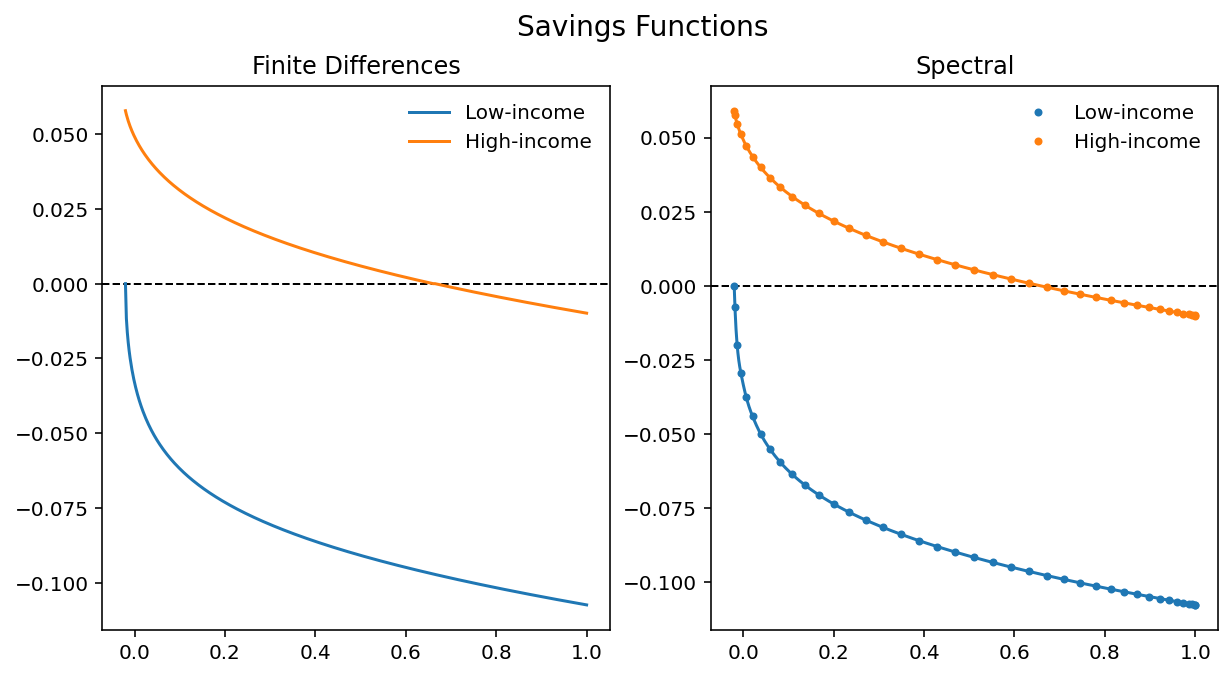

Saved to: two_state_savings_finite_differences_vs_spectral.pdf


In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, s_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, s_fd[I:], 'C1', label='High-income')
ax[0].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[0].set_title('Finite Differences')
ax[0].legend(loc='upper right', frameon=False)

ax[1].plot(a_sp, s_sp[:N], 'C0.', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd), 'C0')
ax[1].plot(a_sp, s_sp[N:], 'C1.', label='High-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd), 'C1')
ax[1].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[1].set_title('Spectral')
ax[1].legend(loc='upper right', frameon=False)

fig.suptitle('Savings Functions', size=14)
savefig(fig, 'two_state_savings_finite_differences_vs_spectral')

## Error plots

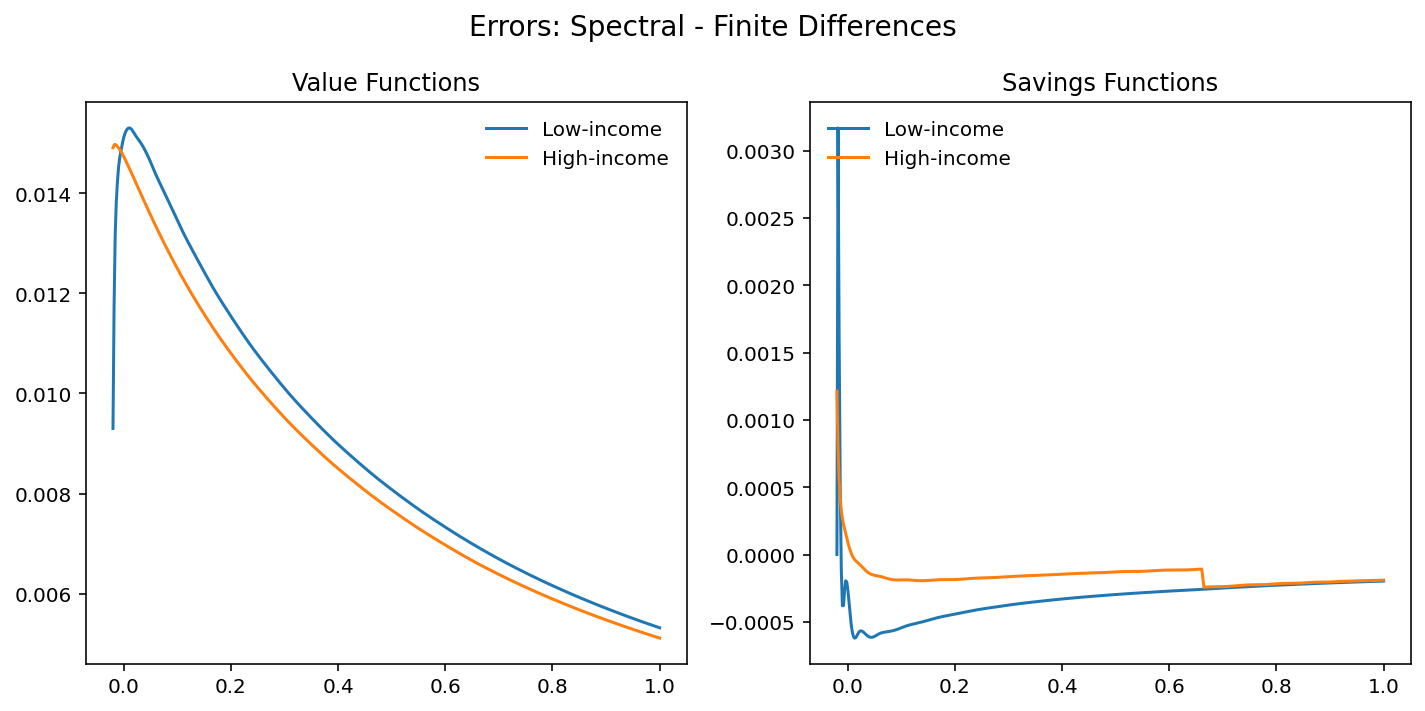

Saved to: two_state_errors_value_functions_and_savings_functions.pdf


In [93]:
fd_bc_low = v_fd[0] + (a_fd-amin)*du(zlow+r*amin)
fd_sp_low = v_sp[0] + (a_fd-amin)*du(zlow+r*amin)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd)-v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd)-v_fd[I:], 'C1', label='High-income')
ax[0].legend(loc='upper right', frameon=False)
ax[0].set_title('Value Functions')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd)-s_fd[:I], 'C0', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd)-s_fd[I:], 'C1', label='High-income')
ax[1].legend(loc='upper left', frameon=False)
ax[1].set_title('Savings Functions')

fig.suptitle('Errors: Spectral - Finite Differences', size=14)
plt.tight_layout()
savefig(fig, 'two_state_errors_value_functions_and_savings_functions')

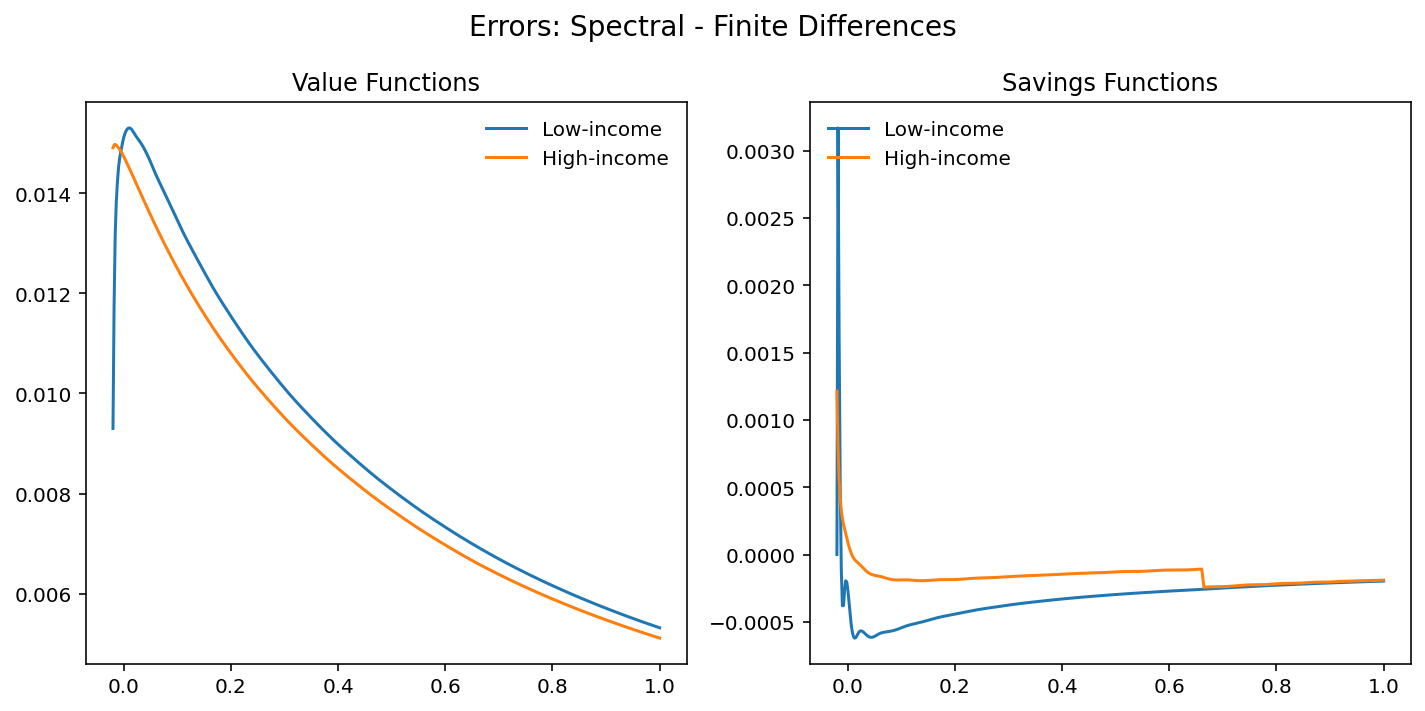

Saved to: two_state_errors_value_functions_and_savings_functions.pdf


In [94]:
fd_bc_low = v_fd[0] + (a_fd-amin)*du(zlow+r*amin)
fd_sp_low = v_sp[0] + (a_fd-amin)*du(zlow+r*amin)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd)-v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd)-v_fd[I:], 'C1', label='High-income')
ax[0].legend(loc='upper right', frameon=False)
ax[0].set_title('Value Functions')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd)-s_fd[:I], 'C0', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd)-s_fd[I:], 'C1', label='High-income')
ax[1].legend(loc='upper left', frameon=False)
ax[1].set_title('Savings Functions')

fig.suptitle('Errors: Spectral - Finite Differences', size=14)
plt.tight_layout()
savefig(fig, 'two_state_errors_value_functions_and_savings_functions')

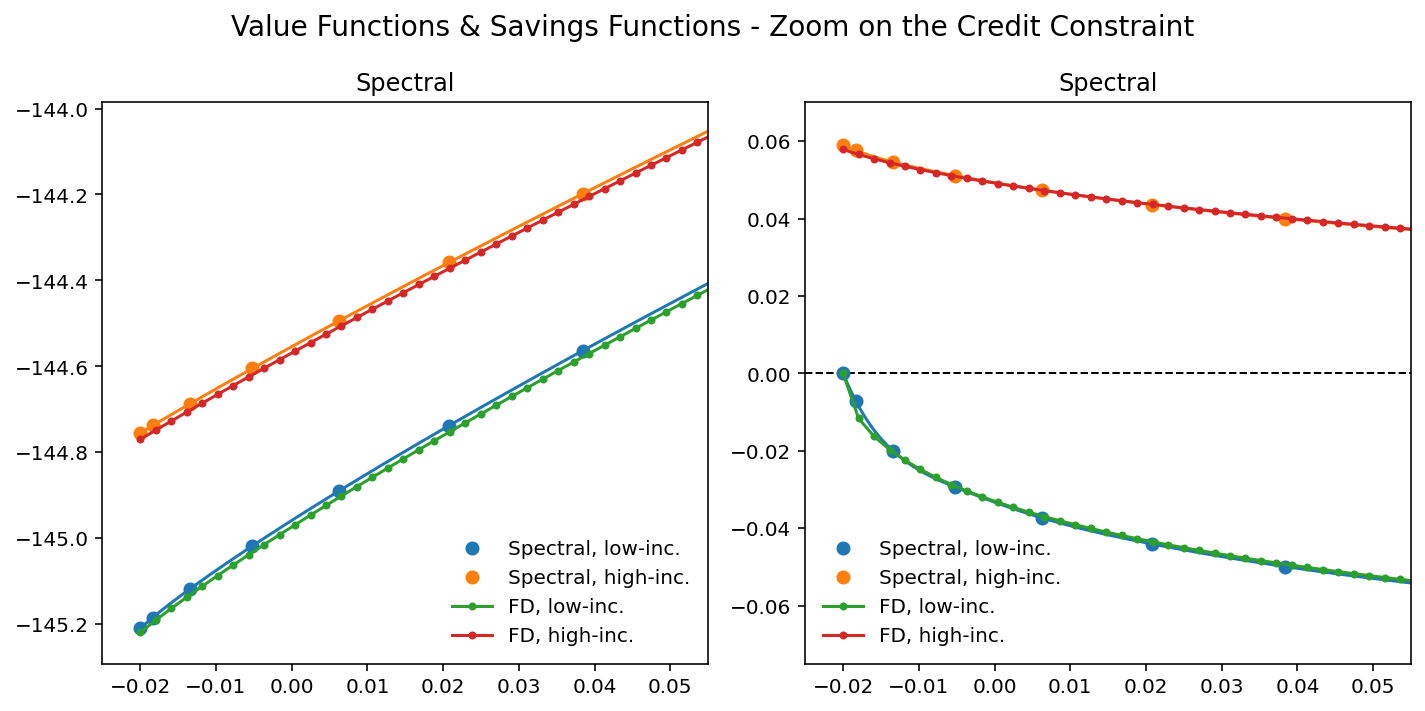

Saved to: two_state_value_functions_savings_finite_differences_vs_spectral_zoombottom.pdf


In [95]:
a_hd = np.linspace(amin, amax, 10000)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()


ax[0].plot(a_sp, v_sp[:N], 'C0o', label='Spectral, low-inc.')
ax[0].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_hd), 'C0')
ax[0].plot(a_sp, v_sp[N:], 'C1o', label='Spectral, high-inc.')
ax[0].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_hd), 'C1')
ax[0].plot(a_fd, v_fd[:I], 'C2.-', label='FD, low-inc.')
ax[0].plot(a_fd, v_fd[I:], 'C3.-', label='FD, high-inc.')
ax[0].set_title('Spectral')
ax[0].legend(loc='lower right', frameon=False)

ax[0].set_xlim([amin-0.005,0.05])
ax[0].set_ylim([1.0005*v_fd[0], 0.9915*v_fd[0]])

ax[1].plot(a_sp, s_sp[:N], 'C0o', label='Spectral, low-inc.')
ax[1].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_hd), 'C0')
ax[1].plot(a_sp, s_sp[N:], 'C1o', label='Spectral, high-inc.')
ax[1].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_hd), 'C1')
ax[1].plot(a_fd, s_fd[:I], 'C2.-', label='FD, low-inc.')
ax[1].plot(a_fd, s_fd[I:], 'C3.-', label='FD, high-inc.')
ax[1].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[1].set_title('Spectral')
ax[1].legend(loc='lower left', frameon=False)

ax[1].set_xlim([amin-0.005,0.055])
ax[1].set_ylim([-0.075, 0.07])

fig.suptitle('Value Functions & Savings Functions - Zoom on the Credit Constraint', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_functions_savings_finite_differences_vs_spectral_zoombottom')

## Simulation consistency checks

In [96]:
deltat = 1e-6

df_sim = pd.DataFrame(index=np.arange(2*I), columns=['v_fd', 'v_fd_sim', 'v_fd_sim_se', 'v_fd_exp',
                                                      'v_sp', 'v_sp_sim', 'v_sp_sim_se', 'v_sp_exp'], dtype='float')

In [97]:
nsim = 100

for a0idx, a0 in enumerate(a_fd):
    for z0idx, z0 in enumerate(z):
        
        z1 = np.random.choice(z, size=nsim, p=(np.eye(2)+deltat*G)[z0idx])
                
        s0_fd = deltat*s_fd[a0idx+z0idx*I]
        u0_fd = u(z0+r*a0-s0_fd)
        a1_fd = a0+s0_fd
        
        if amin <= a1_fd <= amax:
            v1_fd =  (z1==zlow)*sp.interpolate.interp1d(a_fd, v_fd[:I])(a1_fd)+(z1==zhigh)*sp.interpolate.interp1d(a_fd, v_fd[I:])(a1_fd)
            v0_fd_sim = deltat*u0_fd + v1_fd*np.exp(-rho*deltat)

            df_sim.loc[a0idx+z0idx*I,'v_fd'] = v_fd[a0idx+z0idx*I]
            df_sim.loc[a0idx+z0idx*I,'v_fd_sim'] = np.mean(v0_fd_sim)
            df_sim.loc[a0idx+z0idx*I,'v_fd_sim_se'] = np.std(v0_fd_sim)/np.sqrt(nsim)
                    
        s0_sp = (z0==zlow)*deltat*sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a0)+(z0==zhigh)*deltat*sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a0)
        u0_sp = u(z0+r*a0-s0_sp)
        a1_sp = a0+s0_sp
                
        if amin <= a1_sp <= amax:
            v1_sp = (z1==zlow)*sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a1_sp)+(z1==zhigh)*sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a1_sp)
            v0_sp_sim = deltat*u0_sp + v1_sp*np.exp(-rho*deltat)

            df_sim.loc[a0idx+z0idx*I,'v_sp'] = (z0==zlow)*sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a0)+(z0==zhigh)*sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a0)
            df_sim.loc[a0idx+z0idx*I,'v_sp_sim'] = np.mean(v0_sp_sim)
            df_sim.loc[a0idx+z0idx*I,'v_sp_sim_se'] = np.std(v0_sp)/np.sqrt(nsim)

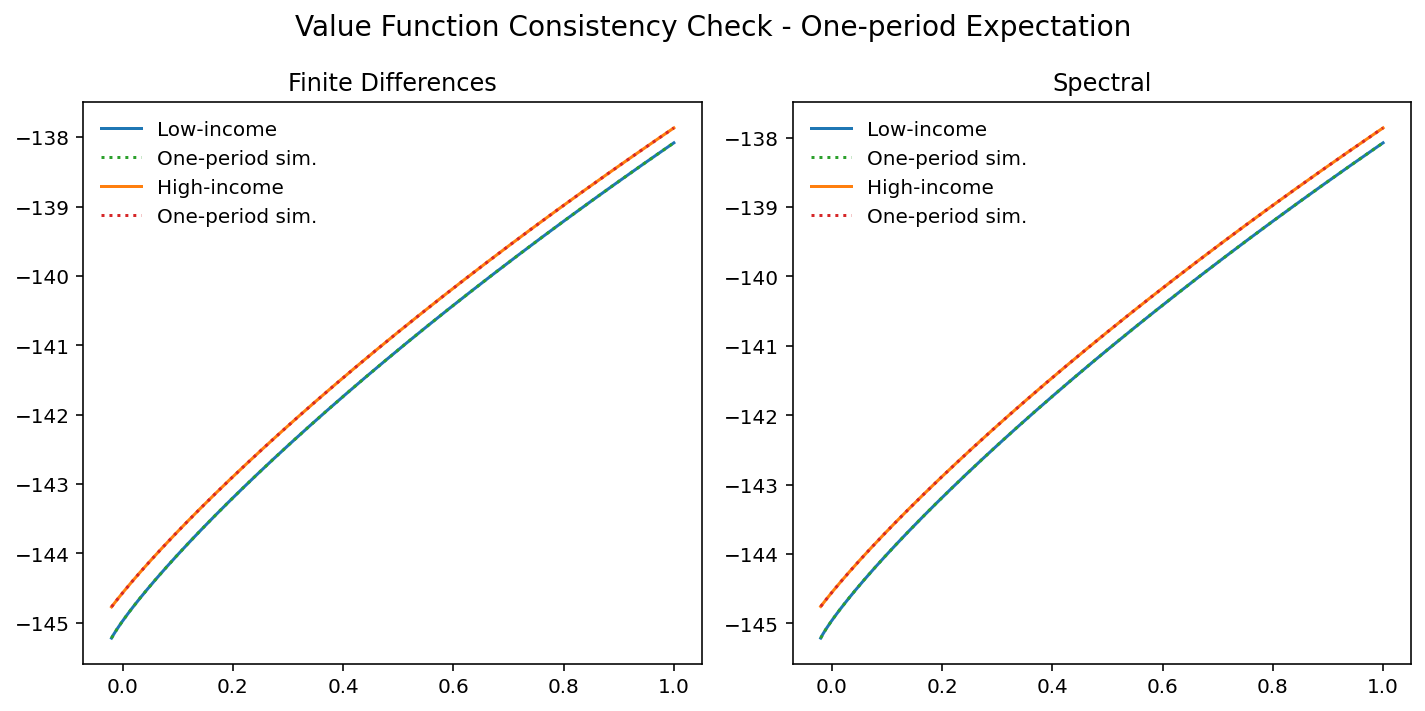

Saved to: two_state_value_function_consistency_check_simulation.pdf


In [98]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, df_sim['v_fd_sim'][:I], 'C2:', label='One-period sim.')
ax[0].plot(a_fd, v_fd[I:], 'C1', label='High-income')
ax[0].plot(a_fd, df_sim['v_fd_sim'][I:], 'C3:', label='One-period sim.')
ax[0].legend(loc='upper left', frameon=False)
ax[0].set_title('Finite Differences')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd), 'C0', label='Low-income')
ax[1].plot(a_fd, df_sim['v_sp_sim'][:I], 'C2:', label='One-period sim.')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd), 'C1', label='High-income')
ax[1].plot(a_fd, df_sim['v_sp_sim'][I:], 'C3:', label='One-period sim.')
ax[1].set_title('Spectral')
ax[1].legend(loc='upper left', frameon=False)

fig.suptitle('Value Function Consistency Check - One-period Expectation', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_function_consistency_check_simulation')

In [99]:
for a0idx, a0 in enumerate(a_fd):
    for z0idx, z0 in enumerate(z):
                        
        s0_fd = deltat*s_fd[a0idx+z0idx*I]
        u0_fd = u(z0+r*a0-s0_fd)
        a1_fd = a0+s0_fd
                            
        if amin <= a1_fd <= amax:
            v1_fd_val = np.array([sp.interpolate.interp1d(a_fd, v_fd[:I])(a1_fd), sp.interpolate.interp1d(a_fd, v_fd[I:])(a1_fd)])
            v1_fd_exp = (np.eye(2)+deltat*G)[z0idx]@v1_fd_val
            v0_fd_exp = deltat*u0_fd + v1_fd_exp*np.exp(-rho*deltat)
            df_sim.loc[a0idx+z0idx*I,'v_fd_exp'] = v0_fd_exp
            
        s0_sp = (z0==zlow)*deltat*sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a0)+(z0==zhigh)*deltat*sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a0)
        u0_sp = u(z0+r*a0-s0_sp)
        a1_sp = a0+s0_sp
          
        if amin <= a1_sp <= amax:
            v1_sp_val = np.array([sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a1_sp), sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a1_sp)])
            v1_sp_exp = (np.eye(2)+deltat*G)[z0idx]@v1_sp_val
            v0_sp_exp = deltat*u0_sp + v1_sp_exp*np.exp(-rho*deltat)
            df_sim.loc[a0idx+z0idx*I,'v_sp_exp'] = v0_sp_exp

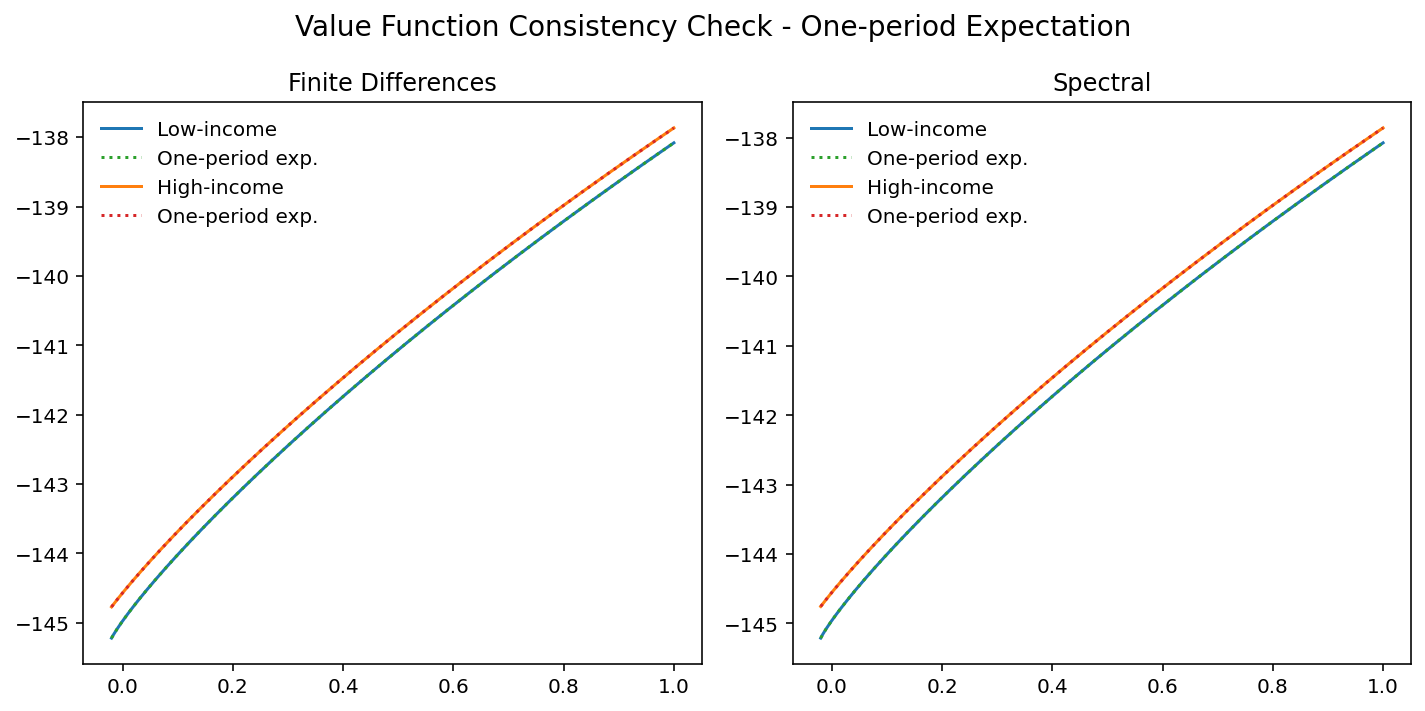

Saved to: two_state_value_function_consistency_check_expectation.pdf


In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, df_sim['v_fd_exp'][:I], 'C2:', label='One-period exp.')
ax[0].plot(a_fd, v_fd[I:], 'C1', label='High-income')
ax[0].plot(a_fd, df_sim['v_fd_exp'][I:], 'C3:', label='One-period exp.')
ax[0].legend(loc='upper left', frameon=False)
ax[0].set_title('Finite Differences')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd), 'C0', label='Low-income')
ax[1].plot(a_fd, df_sim['v_sp_exp'][:I], 'C2:', label='One-period exp.')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd), 'C1', label='High-income')
ax[1].plot(a_fd, df_sim['v_sp_exp'][I:], 'C3:', label='One-period exp.')
ax[1].set_title('Spectral')
ax[1].legend(loc='upper left', frameon=False)

fig.suptitle('Value Function Consistency Check - One-period Expectation', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_function_consistency_check_expectation')

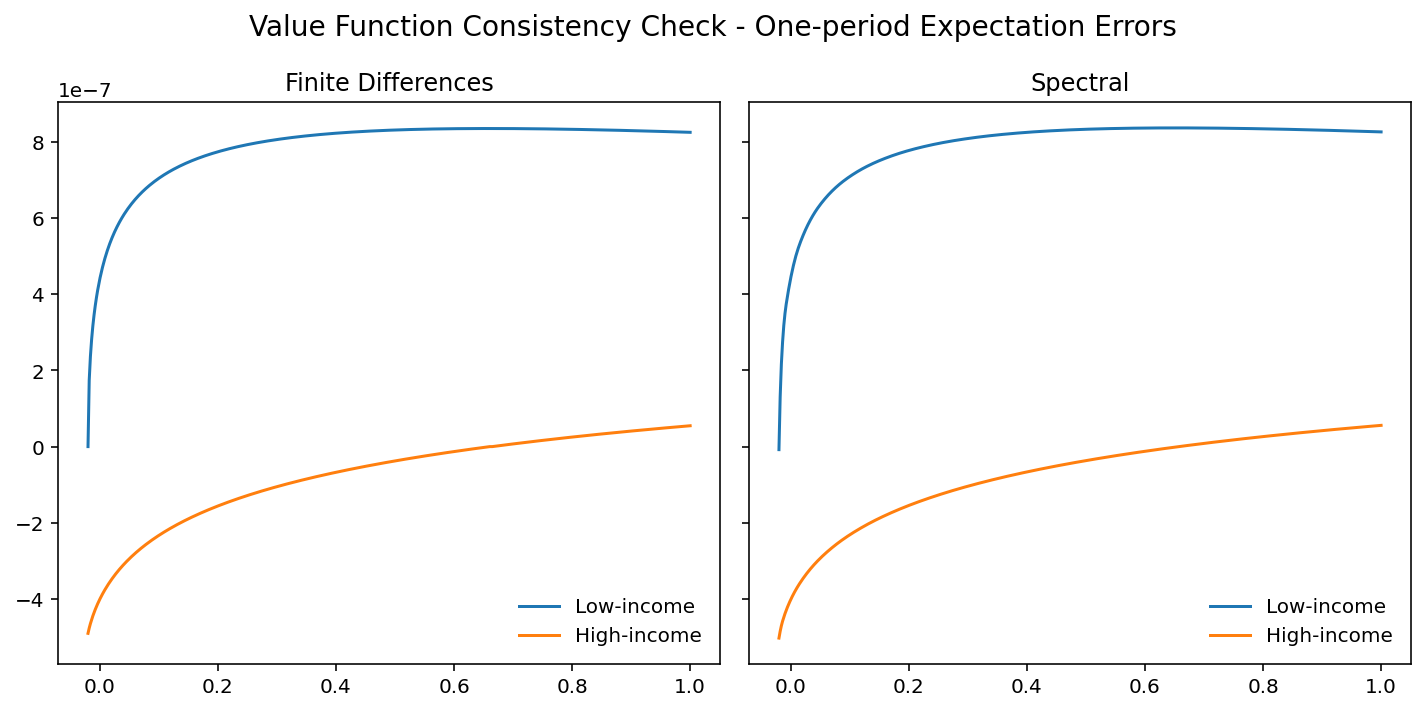

Saved to: two_state_value_function_consistency_check_expectation_errors.pdf


In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, v_fd[:I]-df_sim['v_fd_exp'][:I], 'C0', label='Low-income')
ax[0].plot(a_fd, v_fd[I:]-df_sim['v_fd_exp'][I:], 'C1', label='High-income')
ax[0].legend(loc='lower right', frameon=False)
ax[0].set_title('Finite Differences')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd)-df_sim['v_sp_exp'][:I], 'C0', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd)-df_sim['v_sp_exp'][I:], 'C1', label='High-income')
ax[1].set_title('Spectral')
ax[1].legend(loc='lower right', frameon=False)

fig.suptitle('Value Function Consistency Check - One-period Expectation Errors', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_function_consistency_check_expectation_errors')

In [102]:
print('Average absolute simulation error, finite differences:', (df_sim['v_fd'] - df_sim['v_fd_sim']).dropna().abs().mean())
print('Average absolute simulation error, spectral:', (df_sim['v_sp'] - df_sim['v_sp_sim']).abs().mean())

print('Average absolute expectation error, finite differences:', (df_sim['v_fd'] - df_sim['v_fd_exp']).abs().mean())
print('Average absolute expectation error, spectral:', (df_sim['v_sp'] - df_sim['v_sp_exp']).abs().mean())

Average absolute simulation error, finite differences: 7.701157961435002e-07
Average absolute simulation error, spectral: 7.70173264783125e-07
Average absolute expectation error, finite differences: 4.402323291685661e-07
Average absolute expectation error, spectral: 4.4128373127705344e-07


### To do: HJB Errors

## Matrix plots

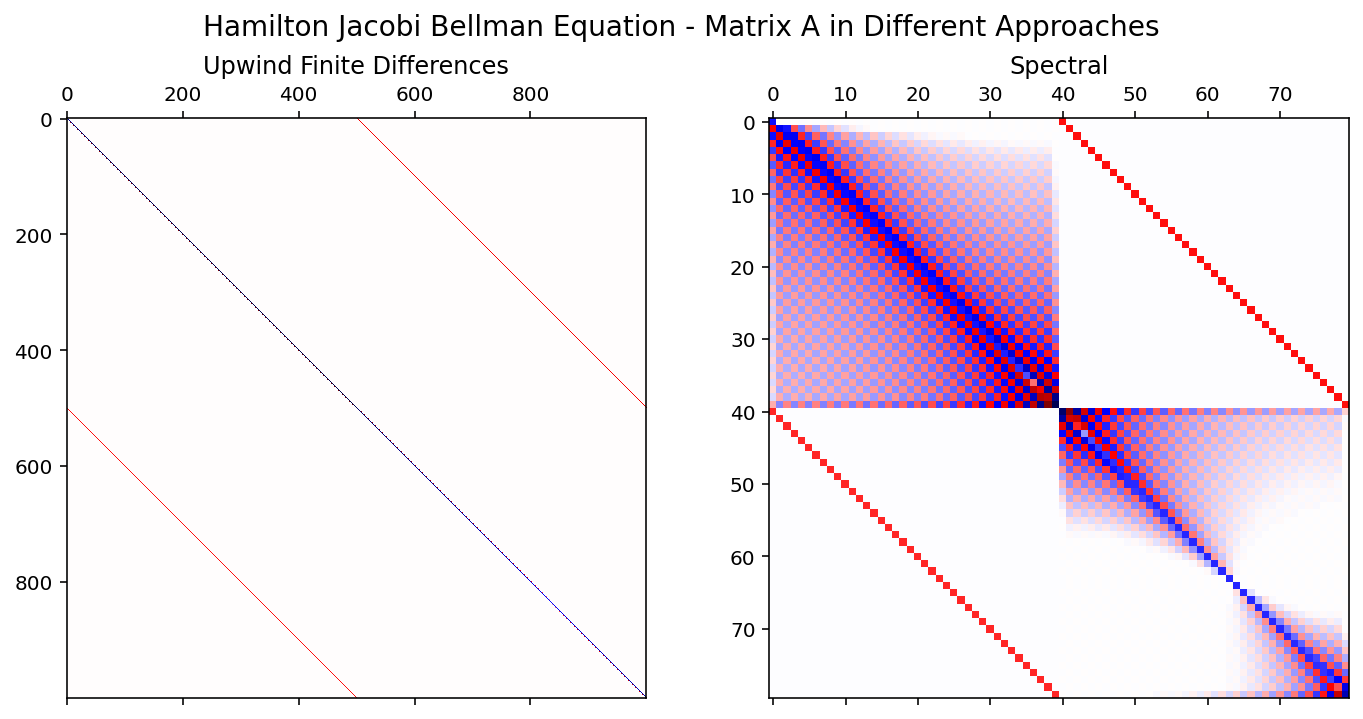

Saved to: two_state_hjb_A_matrix_plot.pdf


In [103]:
matrices = (A_fd.todense(), A)
titles = ['Upwind Finite Differences', 'Spectral']

plotmats(matrices, titles, shape=(1,2), figsize=(10,5), suptitle='Hamilton Jacobi Bellman Equation - Matrix A in Different Approaches', filename='two_state_hjb_A_matrix_plot')

# Kolmogorov Forward Equation

## Helpers

In [104]:
def normalize_distribution(g, a, method='interpolation'):
    if method=='finite':
        da = np.hstack([np.diff(a),0,np.diff(a),0]) #CCC
        return g/np.sum(g*da)
    elif method=='interpolation':
        mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        return g / (mass_low + mass_high)
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        return g / (dirac_mass_low + density_mass_low + dirac_mass_high + density_mass_high)
    else: sys.exit('Method not recognized!')

def solve_zero_eigenvector(C, a, disp=False):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    assert np.isreal(l) and np.isreal(g).all(), "Zero-eigenvector is complex"
    l, g = float(np.real(l)), np.real(g).flatten()
    if disp: print('l:', l)
    return g

def compute_g(C, a, normalize_method='hybrid', disp=True):
    g = solve_zero_eigenvector(C, a, disp)
    g = normalize_distribution(g, a, normalize_method)
    return g

In [105]:
def compute_g_moments(g, a, method=None):
    
    assert len(a) == len(g)/2
    g_assets = (g[:len(a)]+g[len(a):])
        
    if method=='finite':
        da = np.hstack([np.diff(a),0]) #CCC
        dirac_mass_low = g[0]*da[0]
        density_mass_low = np.sum(g[1:len(a)]*da[1:]) # CCC: there has to be a better way...
        dirac_mass_high = g[len(a)]*da[0]
        density_mass_high = np.sum(g[len(a)+1:]*da[1:])
        K = np.sum(g_assets*a*da)
        CDF = (g_assets*da).cumsum()
        gini = (1/K) * np.sum(da*CDF*(1-CDF))
        D1, Q1, Q3, D9 = np.interp([0.1,0.25,0.75,0.9],(da*g_assets).cumsum(),a)
    
    elif method=='interpolation':
        dirac_mass_low = np.nan
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        dirac_mass_high = np.nan
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        K = sp.interpolate.InterpolatedUnivariateSpline(a, g_assets*a).integral(a[0], a[-1])
        g_assets = g_assets / sp.interpolate.CubicSpline(a, g_assets).integrate(a[0], a[-1])
        CDF_assets_ppoly = sp.interpolate.CubicSpline(a, g_assets).antiderivative()
        CDF_assets = CDF_assets_ppoly(a_sp)
        CDF_assets_quantile = lambda q: CDF_assets_ppoly.solve(q, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a, CDF_assets*(1-CDF_assets)).integrate(a[0], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9) 
        
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        K = a[0]*g_assets[0]*(a[1]-a[0]) + sp.interpolate.InterpolatedUnivariateSpline(a[1:], g_assets[1:]*a[1:]).integral(a[1], a[-1])
        dirac_mass = dirac_mass_low + dirac_mass_high
        g_assets = g_assets / (dirac_mass + sp.interpolate.CubicSpline(a[1:], g_assets[1:]).integrate(a[1], amax))
        CDF_assets_trunc_ppoly = sp.interpolate.CubicSpline(a[1:], g_assets[1:]).antiderivative()
        CDF_assets_trunc = CDF_assets_trunc_ppoly(a[1:])+dirac_mass
        CDF_assets_quantile = lambda q: (q<=dirac_mass)*a[0] + (dirac_mass<q)*CDF_assets_trunc_ppoly.solve(q-dirac_mass, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a[1:], CDF_assets_trunc*(1-CDF_assets_trunc)).integrate(a[1], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9)
    
    else: sys.exit('Method not recognized!')
    
    return np.array([dirac_mass_low, density_mass_low, dirac_mass_high, density_mass_high, K, gini, D1, Q1, Q3, D9])

In [106]:
def plot_g(g, a, title='', filename='', interp=False, symlog=False, moment_method=None):
        
    fig, ax = plt.subplots(figsize=(5,5))
    
    if interp:
        a_hd = np.linspace(a[1], a[-1], 1000)
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)])(a_hd), 'C0', label='Low-income')
        ax.plot(a[[0,1]], g[[0,1]], 'C0-')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:])(a_hd), 'C1', label='High-income')
        ax.plot(a_hd, barycentric_interpolate(a_hd, a[1:], g[len(a)+1:]), 'C1', label='High-income')
        ax.plot(a[[0,1]], g[[len(a),len(a)+1]], 'C1-')
    else:
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a, g[:len(a)], 'C0-', label='High-income')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a, g[len(a):], 'C1-', label='High-income')
    
    ax.set_title(title)
    ax.legend(loc='upper right', frameon=False)
    
    if symlog:
        ax[0].set_yscale('symlog', linthresh=1e-3)
        ax.set_yscale('symlog', linthresh=1e-3)
        filename = filename+'_symlog'
    else: ax.set_ylim([-0.5, 5])

    plt.tight_layout()
    savefig(ax, filename)
    
    K, gini = compute_g_moments(g, a, method=moment_method)[[4,5]]
    
    print('K:', K)
    print('Gini:', gini)

## Finite Differences

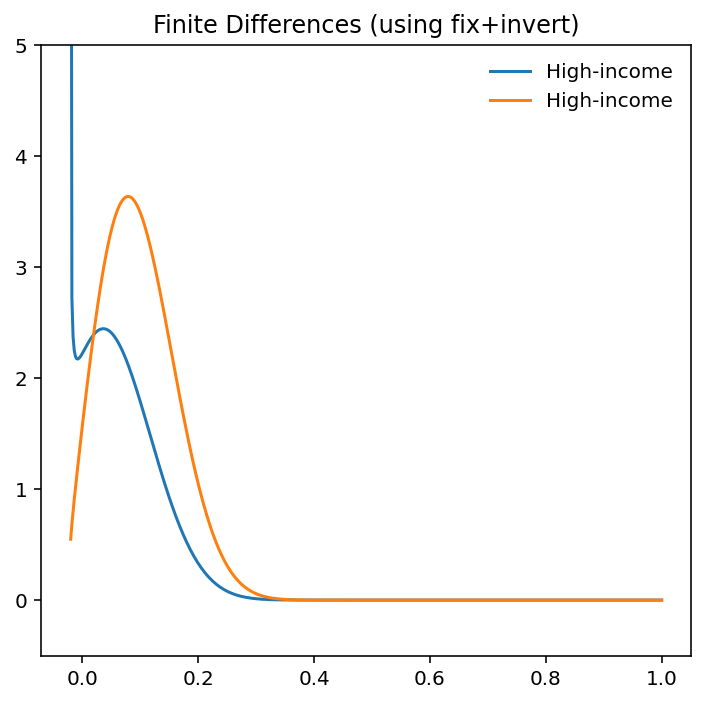

Saved to: two_state_density_finite_differences.pdf
K: 0.08481537316776788
Gini: 0.4306858815628552


In [80]:
# Achdou et al . approach:
AT_fd = A_fd.T.tocsr()
AT_fd.data[1:AT_fd.indptr[1]] = 0
AT_fd.data[0] = 1.
AT_fd.indices[0] = 0
AT_fd.eliminate_zeros()

b = np.zeros((2*I,1))
b[0] = 1.

g_fd = spsolve(AT_fd,b)
g_fd = g_fd/(da_fd*g_fd.sum())

plot_g(g_fd, a_fd, 'Finite Differences (using fix+invert)', 'two_state_density_finite_differences', moment_method='finite')

l: 1.3392186144017228e-16


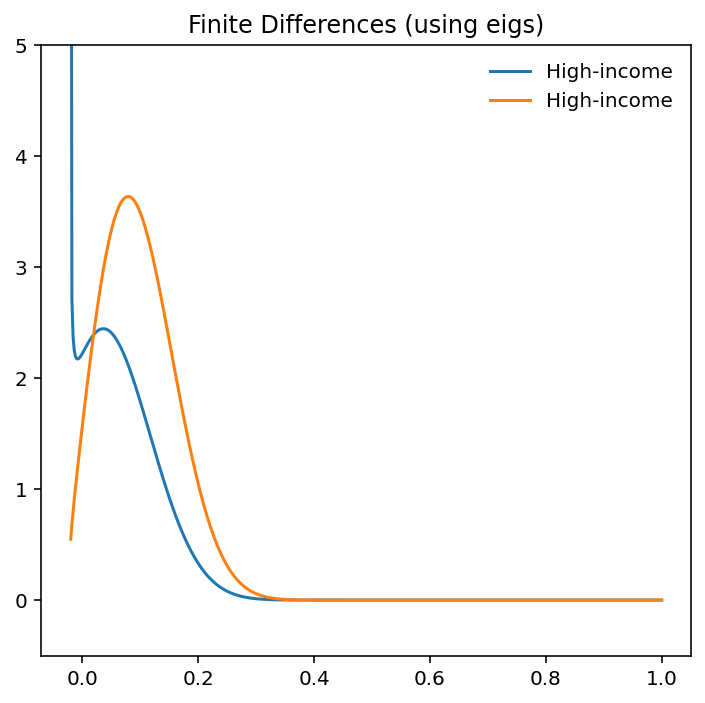

Saved to: two_state_density_finite_differences_eigs.pdf
K: 0.0848153731677675
Gini: 0.43068588156285553


In [107]:
# Eigenvector approach:
g_fd_eigs = compute_g(A_fd.T, a_fd, normalize_method='finite')
plot_g(g_fd_eigs, a_fd, 'Finite Differences (using eigs)', 'two_state_density_finite_differences_eigs', moment_method='finite')

## Fully Spectral

l: 8.386260886358275e-11


ValueError: x and y arrays must be equal in length along interpolation axis.

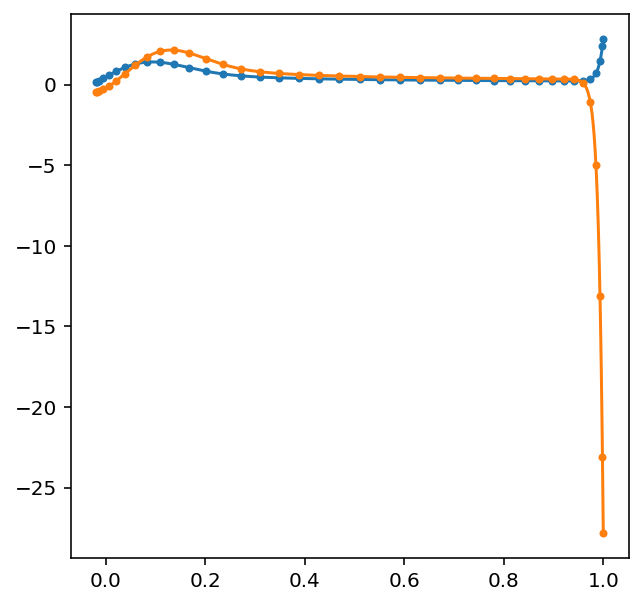

In [108]:
C_fully_spectral = -D_a*s_sp.flatten() + GG.T + 1e-5

g_fully_spectral = compute_g(C_fully_spectral, a_sp, normalize_method='interpolation')
plot_g(g_fully_spectral, a_sp, 'Fully Spectral', 'two_state_density_fully_spectral', interp=True, moment_method='interpolation')

## Dense Finite Volume

In [ ]:
s_sp_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd), sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd)])

l: -9.190190821011745e-16


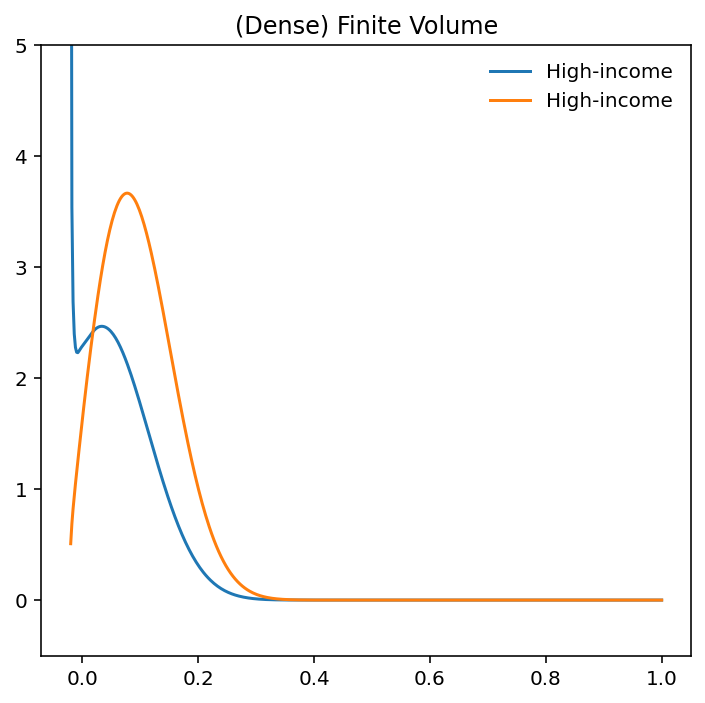

Saved to: two_state_density_finite_volume_dense.pdf
K: 0.08334662525083703
Gini: 0.43494306875645433


In [ ]:
Dfw = (1/da_fd)*(sparse.diags(np.ones(I-1), offsets=1)-sparse.diags(np.ones(I), offsets=0))
D_fw = sparse.kron(sparse.eye(2), Dfw)

Dbw = (1/da_fd)*(sparse.diags(np.ones(I), offsets=0)-sparse.diags(np.ones(I-1), offsets=-1))
D_bw = sparse.kron(sparse.eye(2), Dbw)

C_fv_dense = sparse.kron(G.T,sparse.eye(I)) - D_bw*sparse.diags(np.maximum(s_sp_interp, 0)) - D_fw*sparse.diags(np.minimum(s_sp_interp, 0))

g_fv_dense = compute_g(C_fv_dense, a_fd, normalize_method='finite')
plot_g(g_fv_dense, a_fd, '(Dense) Finite Volume', 'two_state_density_finite_volume_dense', moment_method='finite')

## Coarse Finite Volume

l: -0.021963748835355467


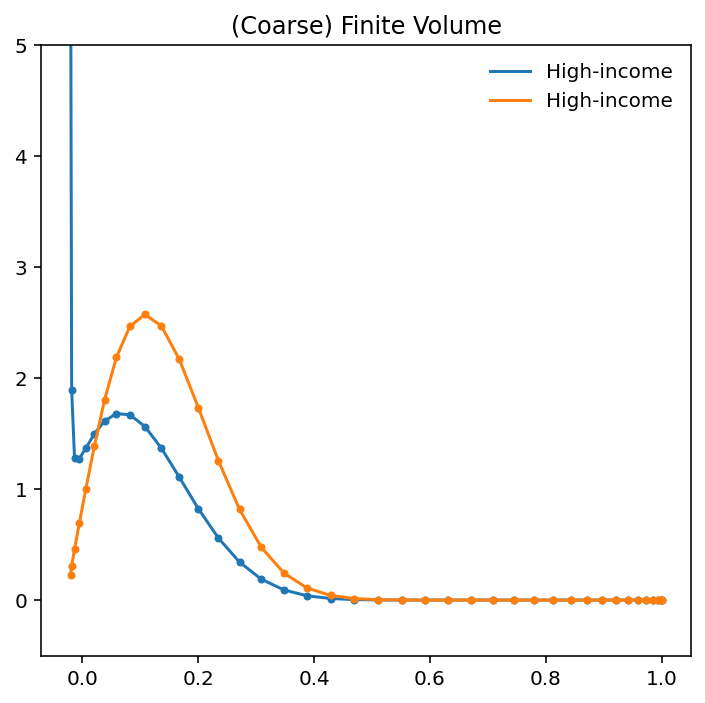

Saved to: two_state_density_finite_volume_coarse.pdf
K: 0.12577267566843026
Gini: 0.3979796208032829


In [ ]:
da_sp_fw = np.hstack([np.diff(a_sp),a_sp[-1]-a_sp[-2]])
Dfw = sparse.diags(1/da_sp_fw,0)*(sparse.diags(np.ones(N-1), offsets=1)-sparse.diags(np.ones(N), offsets=0))
D_fw = sparse.kron(sparse.eye(2), Dfw)

da_sp_bw = np.hstack([a_sp[1]-a_sp[0],np.diff(a_sp)])
Dbw = sparse.diags(1/da_sp_bw,0)*(sparse.diags(np.ones(N), offsets=0)-sparse.diags(np.ones(N-1), offsets=-1))
D_bw = sparse.kron(sparse.eye(2), Dbw)

C_fv_coarse = sparse.kron(G.T,sparse.eye(N)) - D_bw*sparse.diags(np.maximum(s_sp,0)) - D_fw*sparse.diags(np.minimum(s_sp, 0))

g_fv_coarse = compute_g(C_fv_coarse, a_sp, normalize_method='finite')
plot_g(g_fv_coarse, a_sp, '(Coarse) Finite Volume', 'two_state_density_finite_volume_coarse', moment_method='finite')

## Mixed Spectral / Finite Volume 

l: -0.0025145691864449796


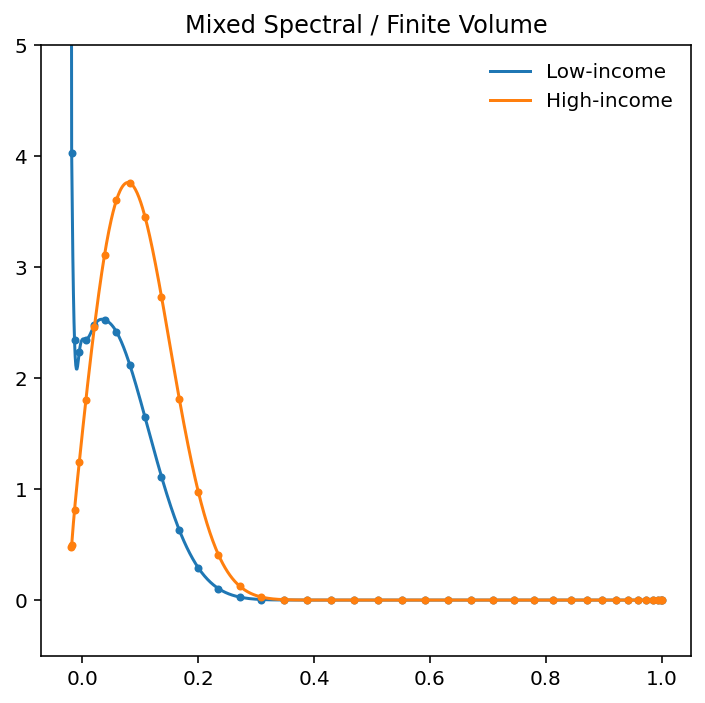

Saved to: two_state_density_mixed_spectral_finite_volume.pdf
K: 0.08332147987890086
Gini: 0.42498656599289586


In [ ]:
da_sp = a_sp[1]-a_sp[0]

Da_cut = np.zeros_like(Da)
Da_cut[1:,1:] = dm.poldif(a_sp[1:], 1)[0]
D_a_cut = np.kron(np.eye(2), Da_cut)

C_mixed = -D_a_cut*s_sp.flatten() + GG.T

# (Backward) inflows-outflows for low-income @ bottom constraint
C_mixed[0,0], C_mixed[0,1], C_mixed[0,N] = -lambda1, -s_sp.flatten()[1]/da_sp, lambda2

# (Forward) inflows-outflows for high-income @ bottom constraint
C_mixed[N,0], C_mixed[N,N] = lambda1, -lambda2-s_sp.flatten()[N]/da_sp

# Outflows-outflows for high-income @ bottom constraint
C_mixed[N+1,:], C_mixed[N+1,N], C_mixed[N+1,N+1] = 0, s_sp.flatten()[N]/da_sp, -s_sp.flatten()[N+1]/da_sp

# Zero mass @ top constraint as savings are negative
C_mixed[N-1,:], C_mixed[N-1,N-1] = 0., 1.
C_mixed[-1,:], C_mixed[-1,-1] = 0., 1.

g_mixed = compute_g(C_mixed, a_sp, normalize_method='hybrid')
plot_g(g_mixed, a_sp, 'Mixed Spectral / Finite Volume', 'two_state_density_mixed_spectral_finite_volume', interp=True, moment_method='hybrid')

## Plots

### Matrix plots

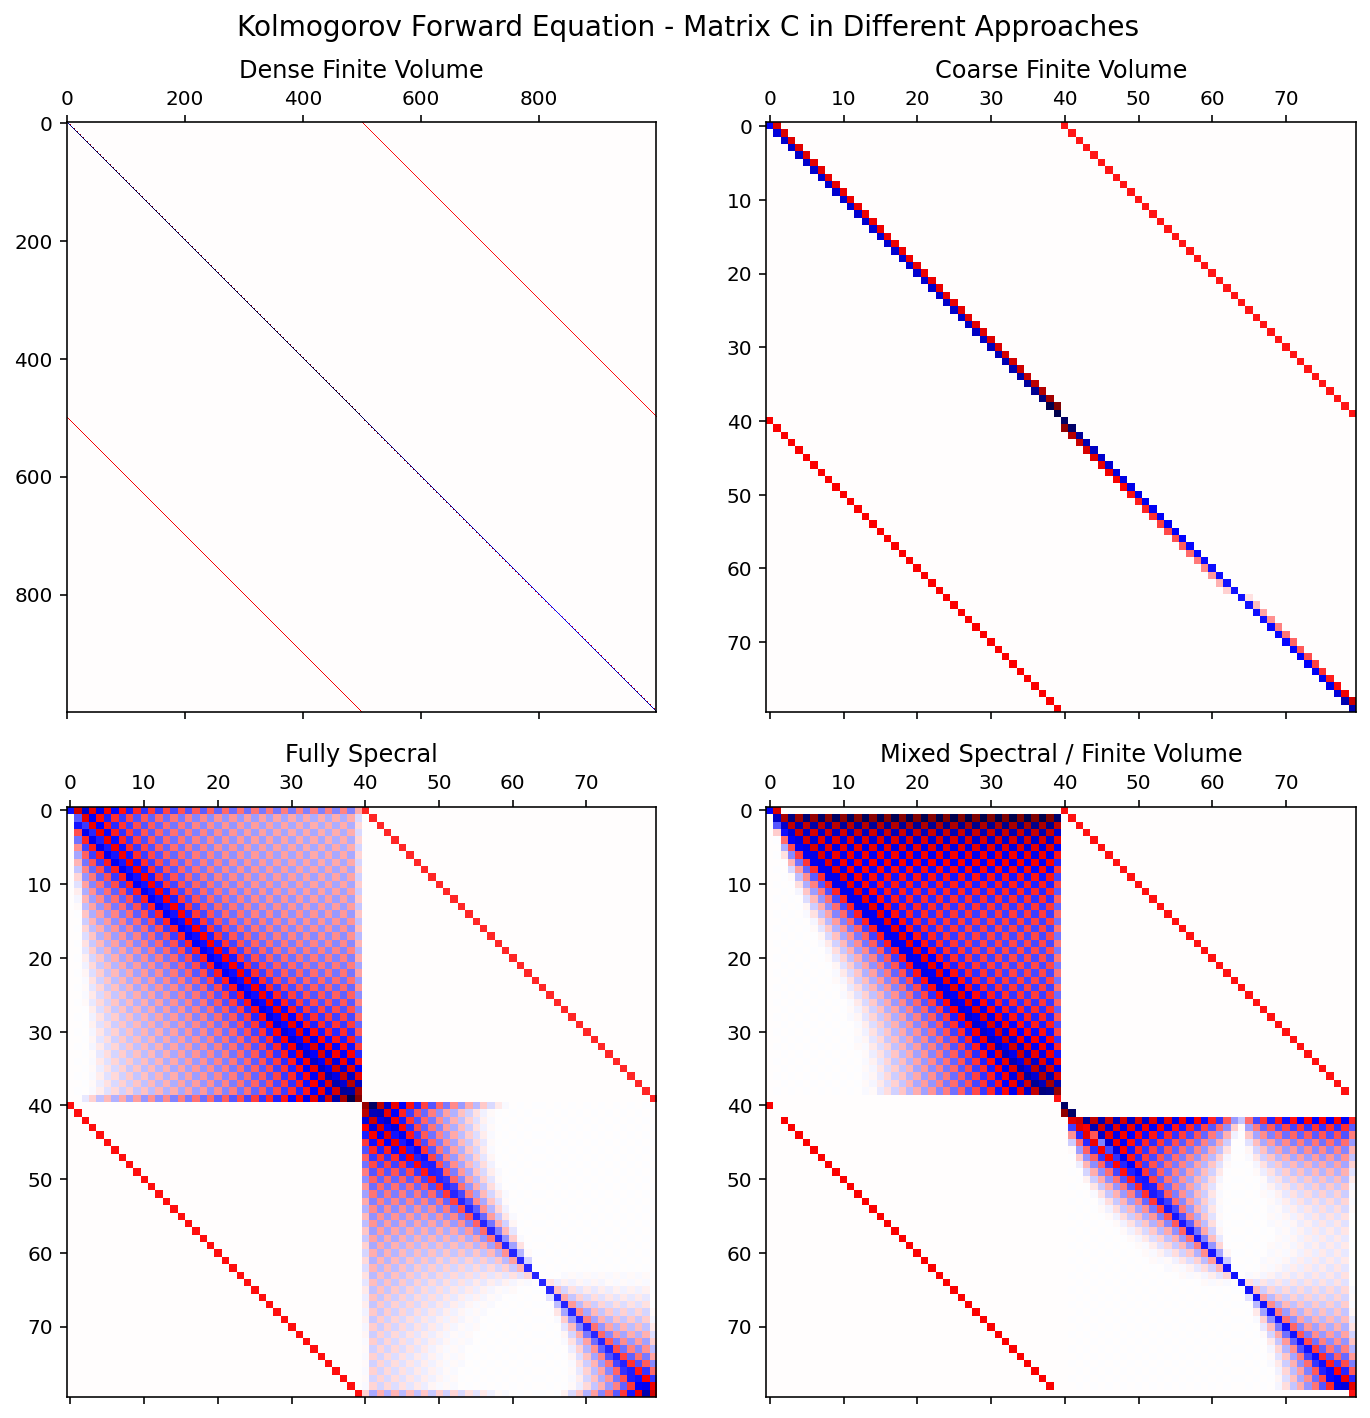

Saved to: two_state_kfe_C_matrix_plot.pdf


In [ ]:
matrices = (C_fv_dense.todense(), C_fv_coarse.todense(), C_fully_spectral, C_mixed)
titles = ['Dense Finite Volume', 'Coarse Finite Volume', 'Fully Specral', 'Mixed Spectral / Finite Volume']

plotmats(matrices, titles, shape=(2,2), figsize=(10,10), suptitle='Kolmogorov Forward Equation - Matrix C in Different Approaches', filename='two_state_kfe_C_matrix_plot')

## Side-by-side plot

# Benchmark

In [ ]:
Nmin, Nmax = 24, 500
Imin, Imax = 100, 5000

nbenchmark = (Nmax-Nmin)//2+1

In [ ]:
moments = ['dirac_mass_low', 'density_mass_low', 'dirac_mass_high', 'density_mass_high', 'K', 'gini', 'D1', 'Q1', 'Q3', 'D9']
computed_moments = ['total_mass_low', 'total_mass_high', 'IQR', 'IDR']

times = ['time_prolegomena', 'time_solve_hjb', 'time_solve_kfe', 'time_compute_moments']
computed_times = ['time_total']

functions = ['value', 'savings']
error_types = ['l1_error', 'l2_error', 'linf_error']
function_errors = [f+'_'+e for f in functions for e in error_types]

In [ ]:
def calc_hd_error(function, a, function_hd, a_hd, interp_method, n=10000):
    assert len(a)==len(function)/2
    assert len(a_hd)==len(function_hd)/2
    
    a_uhd = np.linspace(a[0], a[-1], n)
    
    if interp_method=='polynomial':
        function_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a, function[:len(a)])(a_uhd), sp.interpolate.InterpolatedUnivariateSpline(a, function[:len(a)])(a_uhd)])
        function_hd_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_hd, function_hd[:len(a_hd)])(a_uhd), sp.interpolate.InterpolatedUnivariateSpline(a_hd, function_hd[:len(a_hd)])(a_uhd)])
    elif interp_method=='linear':
        function_interp = np.hstack([np.interp(a_uhd, a, function[:len(a)]), np.interp(a_uhd, a, function[:len(a)])])
        function_hd_interp = np.hstack([np.interp(a_uhd, a_hd, function_hd[:len(a_hd)]), np.interp(a_uhd, a_hd, function_hd[:len(a_hd)])])

    l1_error = np.mean(np.abs(function_interp-function_hd_interp))
    l2_error = np.sqrt(np.mean((function_interp-function_hd_interp)**2))
    linf_error = np.max(np.abs(function_interp-function_hd_interp))
    return l1_error, l2_error, linf_error

## Spectral

In [ ]:
def spectral_prolegomena(N):
    
    a_sp, [Da] = dm.chebdif(N, 1)
    a_sp, [Da] = rescale_nodes_and_derivatives(a_sp, [Da], left=amin, right=amax)

    aa_sp = np.tile(a_sp, 2).reshape(-1,1)
    zz_sp = np.repeat(z, N).reshape(-1,1)

    D_a = np.kron(np.eye(2), Da)
    GG = np.kron(G,np.eye(N))
    
    return a_sp, aa_sp, zz_sp, D_a, GG
    
def spectral_solve_hjb(N, a_sp, aa_sp, zz_sp, D_a, GG):

    v_sp = u(zz_sp+r*aa_sp)/rho
    
    for i in range(maxiter):

        delta = 100*(1/N**2)*np.exp(i)

        dv = D_a@v_sp
        c = du_inv(dv)
        s_sp = zz_sp + r*aa_sp - c

        A = s_sp.reshape(-1,1)*D_a + GG
        B = (1/delta + rho)*np.eye(2*N) - A
        b = u(c) + v_sp/delta

        B[0] = D_a[0]
        b[0] = du(zz_sp + r*aa_sp)[0]

        v_old = v_sp.copy()
        v_sp = np.linalg.solve(B,b)

        dist = np.max(np.abs(v_old-v_sp))
        if dist < crit:
            s_sp[np.abs(s_sp)<1e-8] = 0. # CCC
            return v_sp.flatten(), s_sp.flatten()
        elif i==maxiter-1: sys.exit('No convergence!')
    
def spectral_solve_kfe_fv_dense(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp):
    
    a_hd = np.linspace(a_sp[0], a_sp[-1], N*10)
    da_hd = a_hd[1]-a_hd[0]
    
    s_sp_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_hd), sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_hd)])
    
    Dfw = (1/da_hd)*(sparse.diags(np.ones(N*10-1), offsets=1)-sparse.diags(np.ones(N*10), offsets=0))
    D_fw = sparse.kron(sparse.eye(2), Dfw)

    Dbw = (1/da_hd)*(sparse.diags(np.ones(N*10), offsets=0)-sparse.diags(np.ones(N*10-1), offsets=-1))
    D_bw = sparse.kron(sparse.eye(2), Dbw)

    C_fv_dense = sparse.kron(G.T,sparse.eye(N*10)) - D_bw*sparse.diags(np.maximum(s_sp_interp, 0)) - D_fw*sparse.diags(np.minimum(s_sp_interp, 0))

    g_fv_dense = compute_g(C_fv_dense, a_hd, normalize_method='finite', disp=False)

    return g_fv_dense, a_hd

def spectral_solve_kfe_fv_coarse(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp):
    
    da_sp_fw = np.hstack([np.diff(a_sp),a_sp[-1]-a_sp[-2]])
    Dfw = sparse.diags(1/da_sp_fw,0)*(sparse.diags(np.ones(N-1), offsets=1)-sparse.diags(np.ones(N), offsets=0))
    D_fw = sparse.kron(sparse.eye(2), Dfw)

    da_sp_bw = np.hstack([a_sp[1]-a_sp[0],np.diff(a_sp)])
    Dbw = sparse.diags(1/da_sp_bw,0)*(sparse.diags(np.ones(N), offsets=0)-sparse.diags(np.ones(N-1), offsets=-1))
    D_bw = sparse.kron(sparse.eye(2), Dbw)

    C_fv_coarse = sparse.kron(G.T,sparse.eye(N)) - D_bw*sparse.diags(np.maximum(s_sp,0)) - D_fw*sparse.diags(np.minimum(s_sp, 0))

    g_fv_coarse = compute_g(C_fv_coarse, a_sp, normalize_method='finite', disp=False)
    
    return g_fv_coarse

def spectral_solve_kfe_mixed(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp):
    
    da_sp = a_sp[1]-a_sp[0]

    Da_cut = np.zeros((N,N))
    Da_cut[1:,1:] = dm.poldif(a_sp[1:], 1)[0]
    D_a_cut = np.kron(np.eye(2), Da_cut)
    C_mixed = -D_a_cut*s_sp.flatten() + GG.T

    C_mixed[0,0], C_mixed[0,1], C_mixed[0,N] = -lambda1, -s_sp.flatten()[1]/da_sp, lambda2
    C_mixed[N,0], C_mixed[N,N] = lambda1, -lambda2-s_sp.flatten()[N]/da_sp
    C_mixed[N+1,:], C_mixed[N+1,N], C_mixed[N+1,N+1] = 0, s_sp.flatten()[N]/da_sp, -s_sp.flatten()[N+1]/da_sp

    C_mixed[N-1,:], C_mixed[N-1,N-1] = 0., 1.
    C_mixed[-1,:], C_mixed[-1,-1] = 0., 1.

    g_sp = compute_g(C_mixed, a_sp, disp=False)

    return g_sp

In [ ]:
kfe_methods = ['None', 'fv_dense', 'fv_coarse', 'hybrid']
spectral_moments_midx, _ = pd.MultiIndex.from_product([kfe_methods, moments+times+computed_moments+computed_times+function_errors], names=['kfe_method','moment']).sortlevel()

In [ ]:
def normalize_distribution(g, a, method='interpolation'):
    if method=='finite':
        da = np.hstack([np.diff(a),0,np.diff(a),0]) #CCC
        return g/np.sum(g*da)
    elif method=='interpolation':
        mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        return g / (mass_low + mass_high)
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        return g / (dirac_mass_low + density_mass_low + dirac_mass_high + density_mass_high)
    else: sys.exit('Method not recognized!')

def solve_zero_eigenvector(C, a, disp=False):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    assert np.isreal(l) and np.isreal(g).all(), "Zero-eigenvector is complex"
    l, g = float(np.real(l)), np.real(g).flatten()
    if disp: print('l:', l)
    return g

def compute_g(C, a, normalize_method='hybrid', disp=True):
    g = solve_zero_eigenvector(C, a, disp)
    g = normalize_distribution(g, a, normalize_method)
    return g

In [ ]:
Ns = np.linspace(Nmin, Nmax, nbenchmark, dtype='int')
spectral_moments = pd.DataFrame(columns=spectral_moments_midx, index=Ns, dtype='float')

for N in tqdm(Ns[::-1]):
    
    time_start = timer()
    a_sp, aa_sp, zz_sp, D_a, GG = spectral_prolegomena(N)
    time_prolegomena = timer()-time_start
    
    time_start = timer()
    v_sp, s_sp = spectral_solve_hjb(N, a_sp, aa_sp, zz_sp, D_a, GG)
    time_solve_hjb = timer()-time_start
    
    if N == Ns[-1]: v_sp_hd, s_sp_hd, a_sp_hd = v_sp.copy(), s_sp.copy(), a_sp.copy()
    spectral_moments.loc[N, ('None',['value_l1_error', 'value_l2_error', 'value_linf_error'])] = calc_hd_error(v_sp, a_sp, v_sp_hd, a_sp_hd, interp_method='polynomial')
    spectral_moments.loc[N, ('None',['savings_l1_error', 'savings_l2_error', 'savings_linf_error'])] = calc_hd_error(s_sp, a_sp, s_sp_hd, a_sp_hd, interp_method='polynomial')
    
    time_start = timer()
    g_mixed = spectral_solve_kfe_mixed(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp)
    time_solve_kfe_mixed = timer()-time_start
    spectral_moments.loc[N, ('hybrid', moments)] = compute_g_moments(g_mixed, a_sp, method='hybrid')
    time_compute_moments_mixed = timer()-time_start-time_solve_kfe_mixed
    spectral_moments.loc[N, ('hybrid', times)] = time_prolegomena, time_solve_hjb, time_solve_kfe_mixed, time_compute_moments_mixed
    
    time_start = timer()
    g_fv_coarse = spectral_solve_kfe_fv_coarse(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp)
    time_solve_kfe_fv_coarse = timer()-time_start
    spectral_moments.loc[N, ('fv_coarse', moments)] = compute_g_moments(g_fv_coarse, a_sp, method='finite')
    time_compute_moments_fv_coarse = timer()-time_start-time_solve_kfe_fv_coarse
    spectral_moments.loc[N, ('fv_coarse', times)] = time_prolegomena, time_solve_hjb, time_solve_kfe_fv_coarse, time_compute_moments_fv_coarse

    time_start = timer()
    g_fv_dense, a_hd = spectral_solve_kfe_fv_dense(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp)
    time_solve_kfe_fv_dense = timer()-time_start
    spectral_moments.loc[N, ('fv_dense', moments)] = compute_g_moments(g_fv_dense, a_hd, method='finite')
    time_compute_moments_fv_dense = timer()-time_start-time_solve_kfe_fv_dense
    spectral_moments.loc[N, ('fv_dense', times)] = time_prolegomena, time_solve_hjb, time_solve_kfe_fv_dense, time_compute_moments_fv_dense

  0%|          | 0/239 [00:00<?, ?it/s]

/var/folders/0x/j6rztv6n3g75z6zj86jkb5t00000gp/T/ipykernel_75610/2627228341.py:4: RuntimeWarning: invalid value encountered in power
  def du_inv(x): return x**(-1/gamma)
/var/folders/0x/j6rztv6n3g75z6zj86jkb5t00000gp/T/ipykernel_75610/4167957314.py:20: RuntimeWarning: overflow encountered in exp
  delta = 100*(1/N**2)*np.exp(i)


SystemExit: No convergence!

/Users/constantinschesch/opt/anaconda3/envs/python310/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
spectral_moments.loc[:,(slice(None),'total_mass_low')] = spectral_moments.loc[:,(slice(None),'dirac_mass_low')].values+spectral_moments.loc[:,(slice(None),'density_mass_low')].values
spectral_moments.loc[:,(slice(None),'total_mass_high')] = spectral_moments.loc[:,(slice(None),'dirac_mass_high')].values+spectral_moments.loc[:,(slice(None),'density_mass_high')].values

spectral_moments.loc[:,(slice(None),'IQR')] = spectral_moments.loc[:,(slice(None),'Q3')].values/spectral_moments.loc[:,(slice(None),'Q1')].values
spectral_moments.loc[:,(slice(None),'IDR')] = spectral_moments.loc[:,(slice(None),'D9')].values/spectral_moments.loc[:,(slice(None),'Q1')].values

for method in kfe_methods:
    spectral_moments.loc[:,(method,'time_total')] = spectral_moments.loc[:,(method,times)].sum(axis=1)

## Upwind Finite Differences

In [ ]:
def fd_prolegomena(I):

    a_fd = np.linspace(amin, amax, I)
    da_fd = a_fd[1]-a_fd[0]

    aa_fd = np.tile(a_fd,(2,1))
    zz_fd = np.tile(z,(I,1)).T
    
    z_transition = sparse.kron(G,sparse.eye(I), format='csr')

    v_old = np.zeros((2,I))
    g = np.zeros((2,I))
    dv = np.zeros((2,I-1))
    cf = np.zeros((2,I-1))
    c0 = np.zeros((2,I))
    ssf = np.zeros((2,I))
    ssb = np.zeros((2,I))
    is_backward = np.zeros((2,I))
    is_forward = np.zeros((2,I))
    diag_helper = np.zeros((2,I))        
    A = z_transition.copy()
    B = z_transition.copy()
    
    return a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B
    
def fd_solve_hjb(I, a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B):
    
    v_fd = u(r*aa_fd + zz_fd)/rho

    for i in range(maxiter):
        
        delta = (1/N**2)*np.exp(i)

        dv = (v_fd[:,1:]-v_fd[:,:-1])/da_fd
        cf = du_inv(dv)
        c0 = r*aa_fd + zz_fd

        ssf[:,:-1] = c0[:,:-1]-cf
        ssb[:,1:] = c0[:,1:]-cf

        is_backward = ssf>0
        is_forward = ssb<0

        c0[:,:-1] += (cf-c0[:,:-1])*is_backward[:,:-1]
        c0[:,1:] += (cf-c0[:,1:])*is_forward[:,1:]

        A = z_transition.copy()
        diag_helper = (-ssf*is_backward/da_fd + ssb*is_forward/da_fd).flatten()
        A += sparse.spdiags(diag_helper,0,2*I,2*I)
        diag_helper = (-ssb*is_forward/da_fd).flatten()
        A += sparse.spdiags(diag_helper[1:],-1,2*I,2*I)
        diag_helper = (ssf*is_backward/da_fd).flatten()
        A += sparse.spdiags(np.hstack((0,diag_helper)),1,2*I,2*I)

        B = sparse.eye(2*I)*(1/delta + rho) - A
        b = u(c0).reshape(-1,1) + v_fd.reshape(-1,1)/delta
        A_fd, v_old, s_fd = A.copy(), v_fd.copy(), (r*aa_fd + zz_fd - c0)
        v_fd = spsolve(B,b).reshape(2,I)

        dist = np.max(np.abs(v_old-v_fd))
        
        if dist < crit: return v_fd.flatten(), A_fd, s_fd.flatten()
        elif i==maxiter-1: sys.exit('No convergence!')
    
def fd_solve_kfe(I, A_fd):
    
        AT_fd = A_fd.T.tocsr()
        b = np.zeros((2*I,1))
        b[0] = 0.1
        AT_fd.data[1:AT_fd.indptr[1]] = 0
        AT_fd.data[0] = 1.0
        AT_fd.indices[0] = 0
        AT_fd.eliminate_zeros()
        
        g_fd = spsolve(AT_fd,b)
        g_fd = g_fd/(da_fd*g_fd.sum())
        
        return g_fd

In [ ]:
Is = np.geomspace(Imin, Imax, nbenchmark).astype('int')
fd_moments = pd.DataFrame(columns=moments, index=Is, dtype='float')

for I in tqdm(Is[::-1]):
                
    time_start = timer()
    a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B = fd_prolegomena(I)
    time_prolegomena = timer()-time_start

    v_fd, A_fd, s_fd = fd_solve_hjb(I, a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B)
    time_solve_hjb = timer()-time_start-time_prolegomena
    
    g_fd = fd_solve_kfe(I, A_fd)
    time_solve_kfe = timer()-time_start-time_prolegomena-time_solve_hjb
    
    fd_moments.loc[I, moments] = compute_g_moments(g_fd, a_fd, method='finite')
    time_compute_moments = timer()-time_start-time_prolegomena-time_solve_hjb-time_solve_kfe
    
    fd_moments.loc[I, times] = time_prolegomena, time_solve_hjb, time_solve_kfe, time_compute_moments
    
    if I == Is[-1]: v_fd_hd, s_fd_hd, g_fd_hd, a_fd_hd = v_fd.copy(), s_fd.copy(), g_fd.copy(), a_fd.copy()
    fd_moments.loc[I, ['value_l1_error', 'value_l2_error', 'value_linf_error']] = calc_hd_error(v_fd, a_fd, v_fd_hd, a_fd_hd, interp_method='linear')
    fd_moments.loc[I, ['savings_l1_error', 'savings_l2_error', 'savings_linf_error']] = calc_hd_error(s_fd, a_fd, s_fd_hd, a_fd_hd, interp_method='linear')

  0%|          | 0/239 [00:00<?, ?it/s]

In [ ]:
fd_moments['total_mass_low'] = fd_moments['dirac_mass_low']+fd_moments['density_mass_low']
fd_moments['total_mass_high'] = fd_moments['dirac_mass_high']+fd_moments['density_mass_high']

fd_moments['IQR'] = fd_moments['Q3']/fd_moments['Q1']
fd_moments['IDR'] = fd_moments['D9']/fd_moments['Q1']

fd_moments['time_total'] = fd_moments[times].sum(axis=1)

### Execution Time vs Number of Nodes

In [ ]:
times_colors = dict(zip(times,['#f08080','#f4978e','#f8ad9d','#fbc4ab']))
times_colors = dict(zip(times,['C0','C1','C2','C3']))
pretty_times = dict(zip(times,['Init.','HJB','KFE','Moments']))

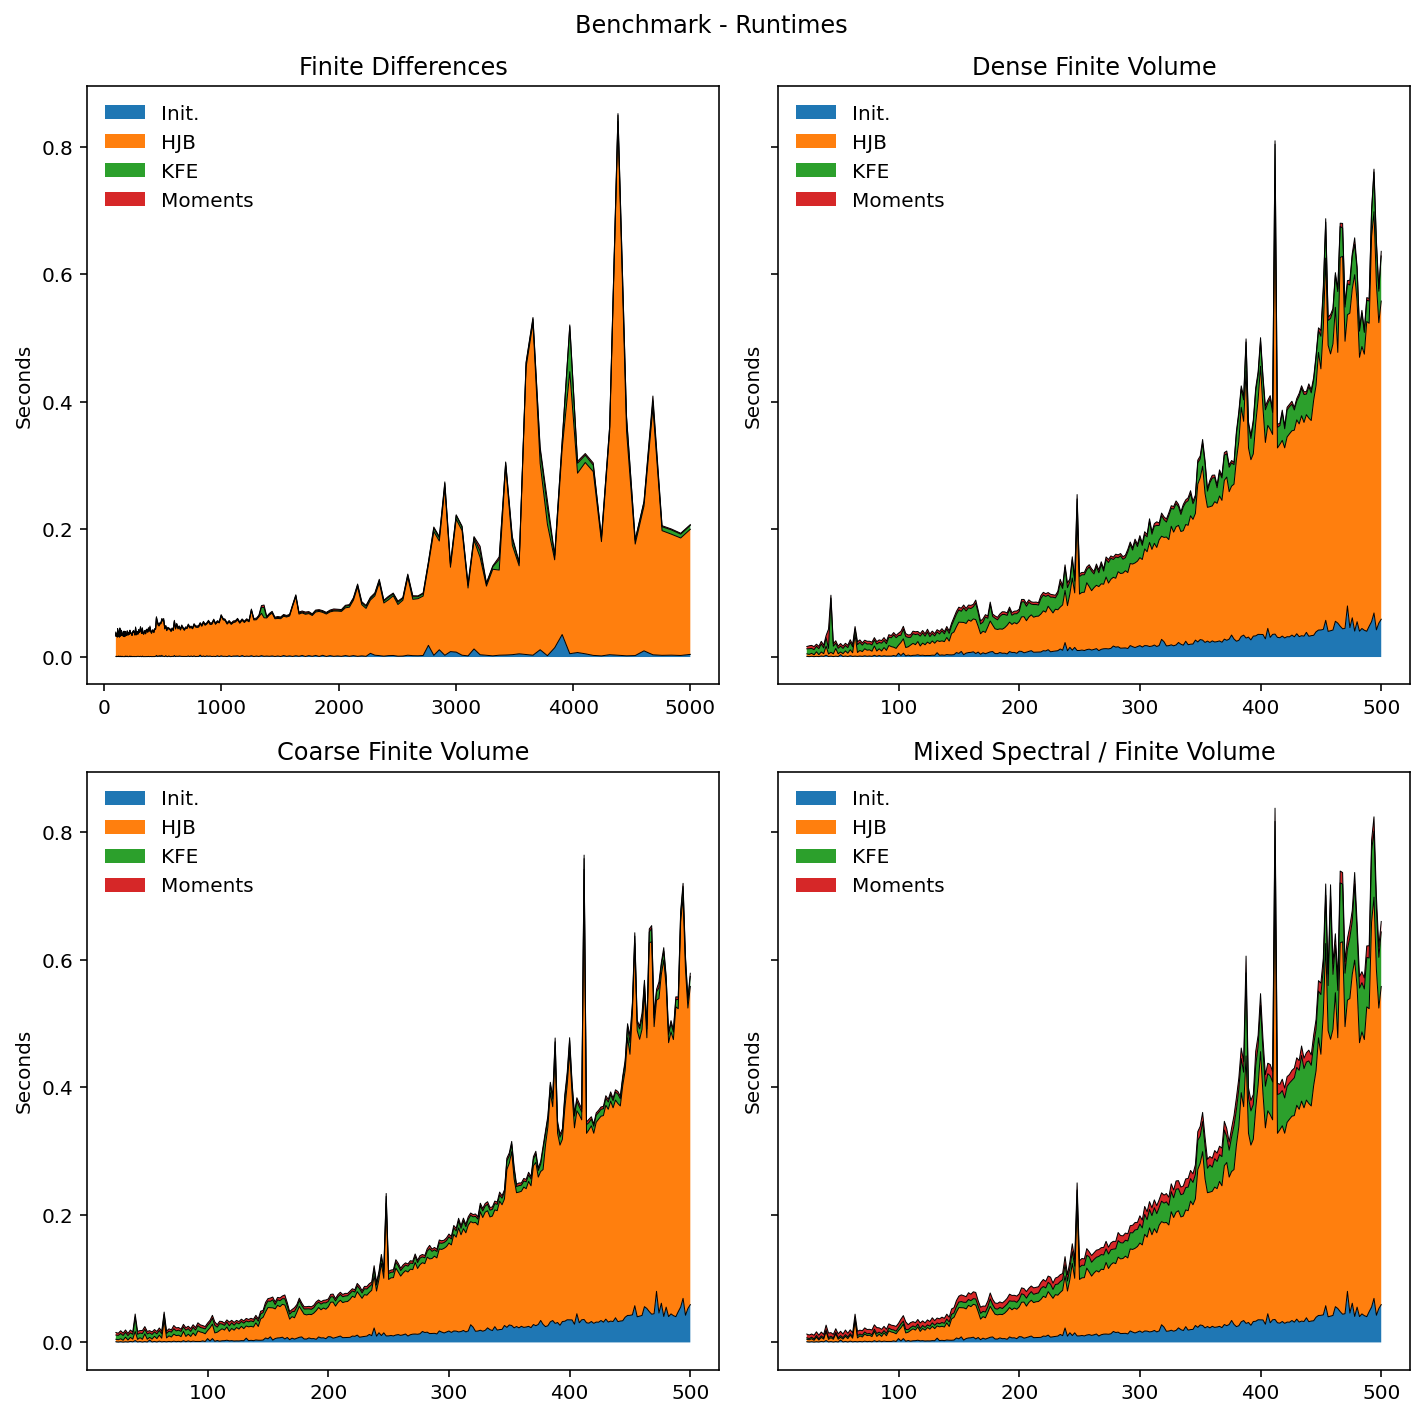

Saved to: two_state_benchmark_runtimes.pdf


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharey=True)
ax = ax.flatten()

dfs_times = [fd_moments, spectral_moments['fv_dense'], spectral_moments['fv_coarse'], spectral_moments['hybrid']]
Xss = [Is, Ns, Ns, Ns]
titles = ['Finite Differences', 'Dense Finite Volume', 'Coarse Finite Volume', 'Mixed Spectral / Finite Volume']

for j, [df_times, Xs, title] in enumerate(zip(dfs_times, Xss, titles)):
    cumsum = 0*df_times[times[0]].values
    for i, time in enumerate(times):
        ax[j].fill_between(Xs, cumsum, cumsum+df_times[time], facecolor=times_colors[time], label=pretty_times[time])
        ax[j].plot(Xs, cumsum+df_times[time], 'k', lw=0.5)
        cumsum += df_times[time]
    ax[j].legend(frameon=False, loc='upper left')
    ax[j].set_title(title)
    ax[j].set_ylabel('Seconds')
    #ax[j].set_yscale('log')

plt.suptitle('Benchmark - Runtimes')
plt.tight_layout()
savefig(fig, 'two_state_benchmark_runtimes')

### Errors vs Number of Nodes

In [ ]:
pretty_error_types = dict(zip(error_types, ['$L^1$ error', '$L^2$ error', '$L^\infty$ error']))
pretty_functions = dict(zip(functions, ['Value Function', 'Savings Function']))

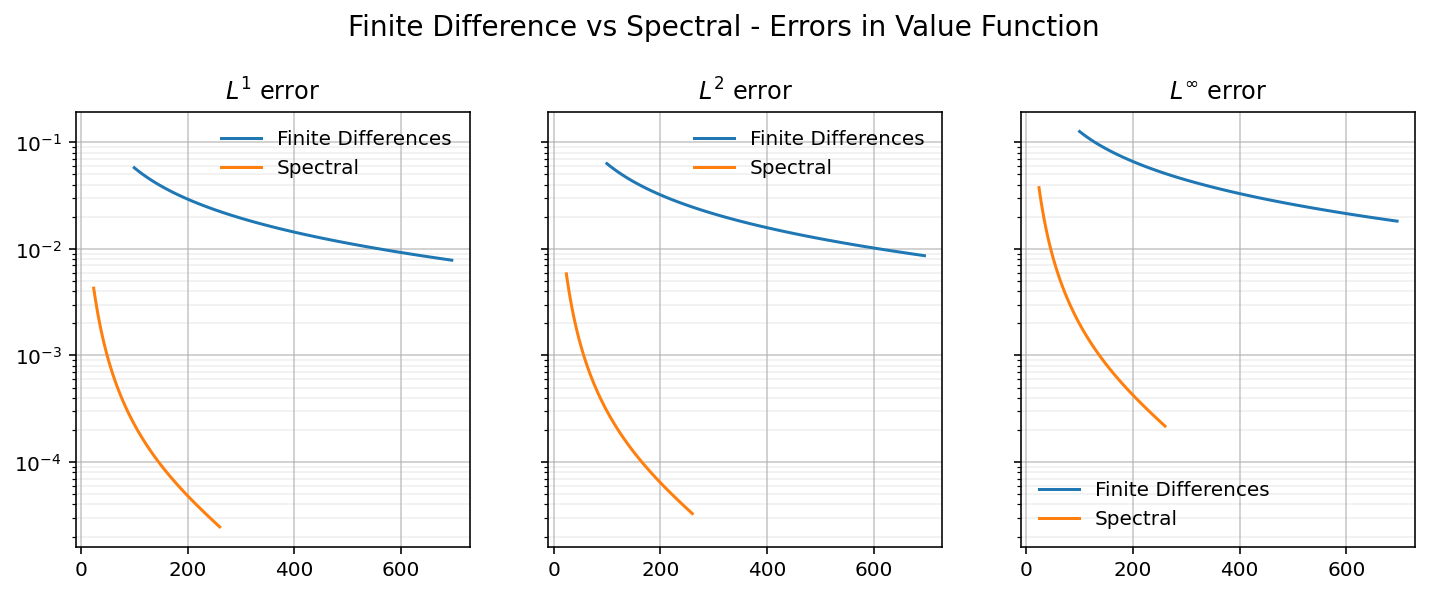

Saved to: two_state_benchmark_errors_value.pdf


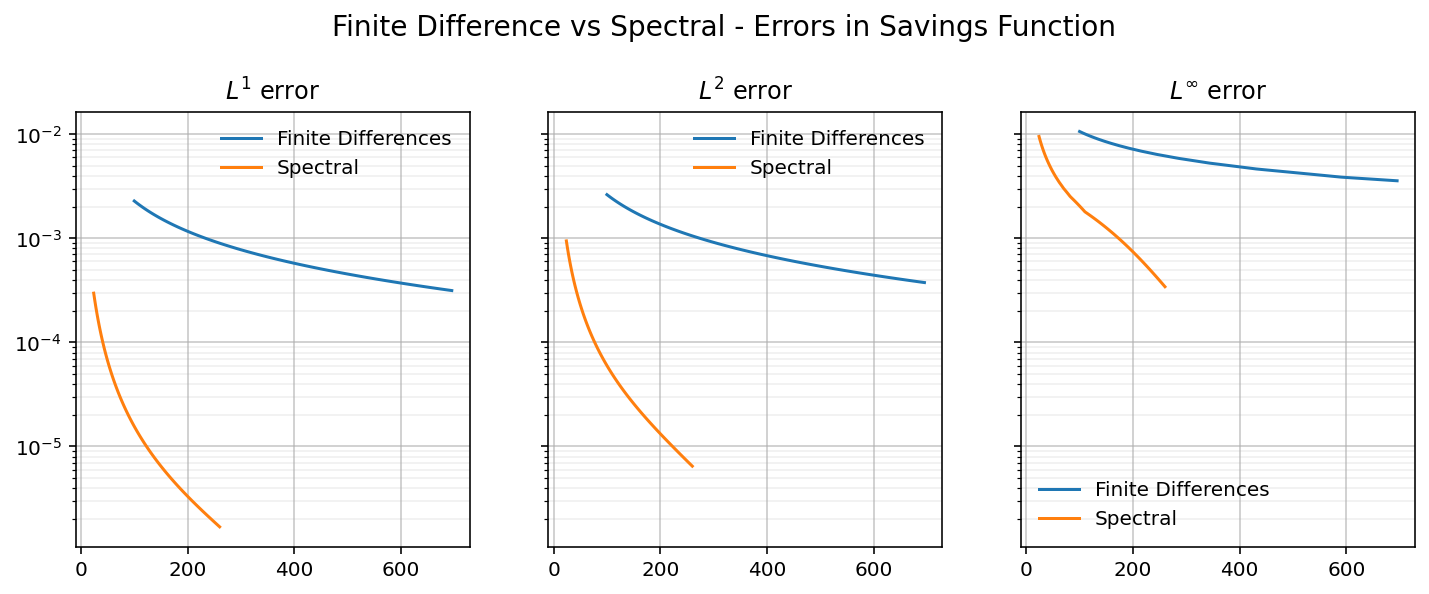

Saved to: two_state_benchmark_errors_savings.pdf


In [ ]:
for function in functions:

    fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    ax = ax.flatten()

    for i, error_type in enumerate(error_types):
        ax[i].plot(Is[:len(Is)//2], fd_moments[function+'_'+error_type][:len(Is)//2], label='Finite Differences')
        ax[i].plot(Ns[:len(Ns)//2], spectral_moments['None', function+'_'+error_type][:len(Ns)//2], label='Spectral')
        
        ax[i].set_yscale('log')
        ax[i].grid(which='minor', alpha=0.2)
        ax[i].grid(which='major', alpha=0.7)
        
        ax[i].set_title(pretty_error_types[error_type])
        ax[i].legend(frameon=False)
        
    plt.suptitle('Finite Difference vs Spectral - Errors in '+pretty_functions[function], size=14, y=1.05)

    savefig(fig, 'two_state_benchmark_errors_'+function)

In [ ]:
prettymoments = {'dirac_mass_low':'Dirac mass, low-income at bottom constraint', 'density_mass_low':'Density mass, low-income', 'total_mass_low':'Total mass, low-income',
                 'dirac_mass_high':'Dirac mass, high-income at bottom constraint', 'density_mass_high':'Density mass, high-income', 'total_mass_high':'Total mass, high-income',
                 'K':'Total capital', 'gini':'Gini coefficient', 'D1':'1st wealth decile', 'Q1':'1st wealth quartile', 'Q3':'3rd wealth quartile', 'D9':'9th wealth decile',
                 'IQR':'Wealth inter-quartile ratio', 'IDR':'Wealth inter-decile ratio',
                 'value_l1_error':'Value $L^1$ Error', 'value_l2_error':'Value $L^2$ Error', 'value_linf_error':'Value $L^\infty$ Error', 
                 'savings_l1_error':'Savings $L^1$ Error', 'savings_l2_error':'Savings $L^2$ Error', 'savings_linf_error':'Savings $L^\infty$ Error', 
                 'density_l1_error':'Density $L^1$ Error', 'density_l2_error':'Density $L^2$ Error', 'density_linf_error':'Density $L^\infty$ Error'}

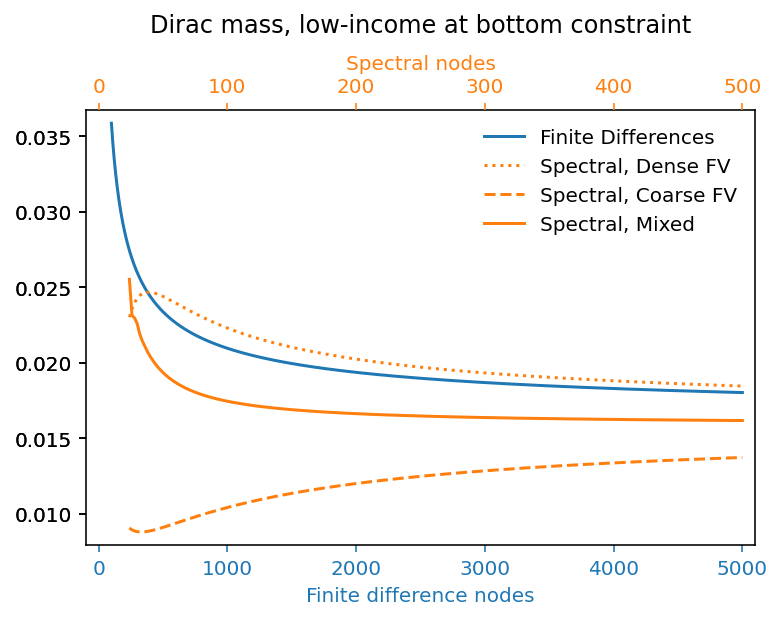

Saved to: two_state_benchmark_errors_dirac_mass_low.pdf


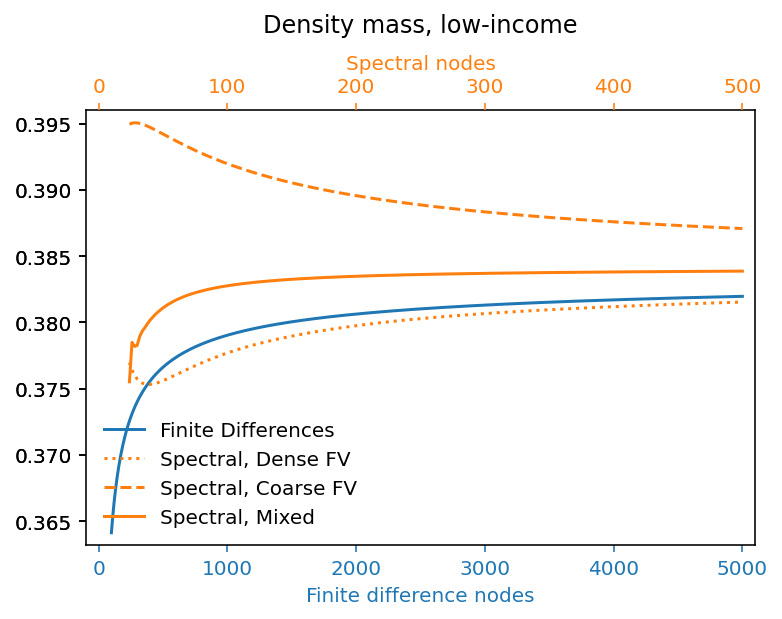

Saved to: two_state_benchmark_errors_density_mass_low.pdf


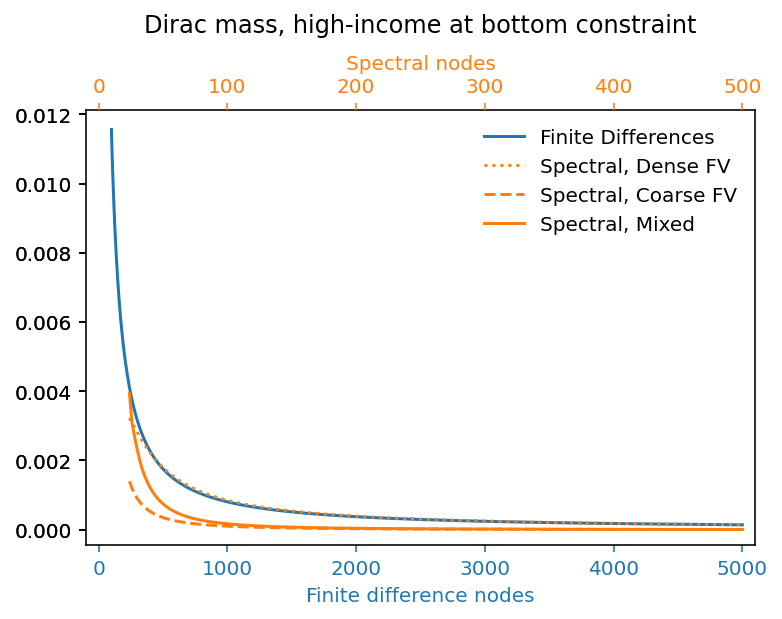

Saved to: two_state_benchmark_errors_dirac_mass_high.pdf


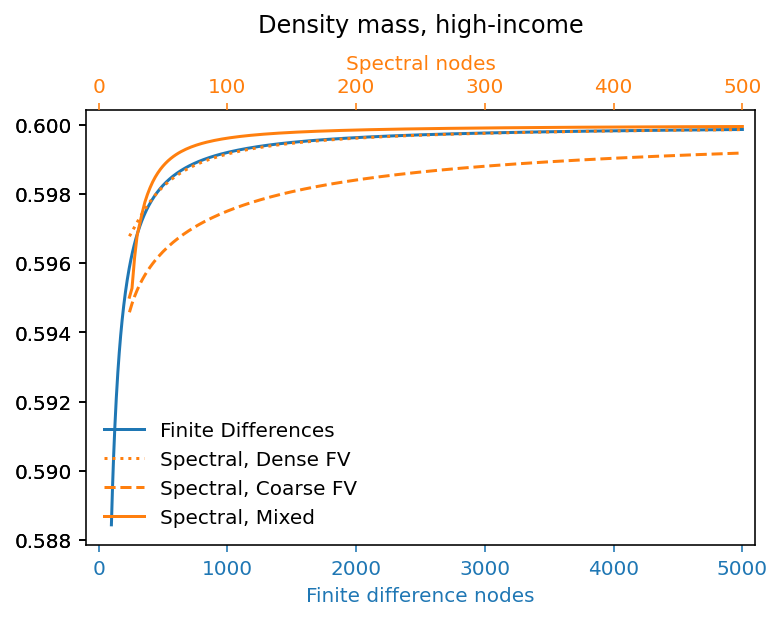

Saved to: two_state_benchmark_errors_density_mass_high.pdf


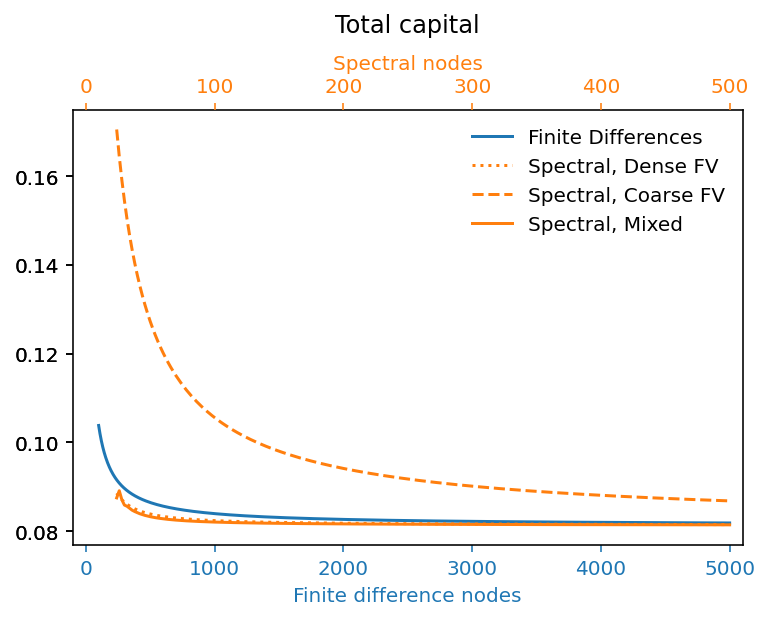

Saved to: two_state_benchmark_errors_K.pdf


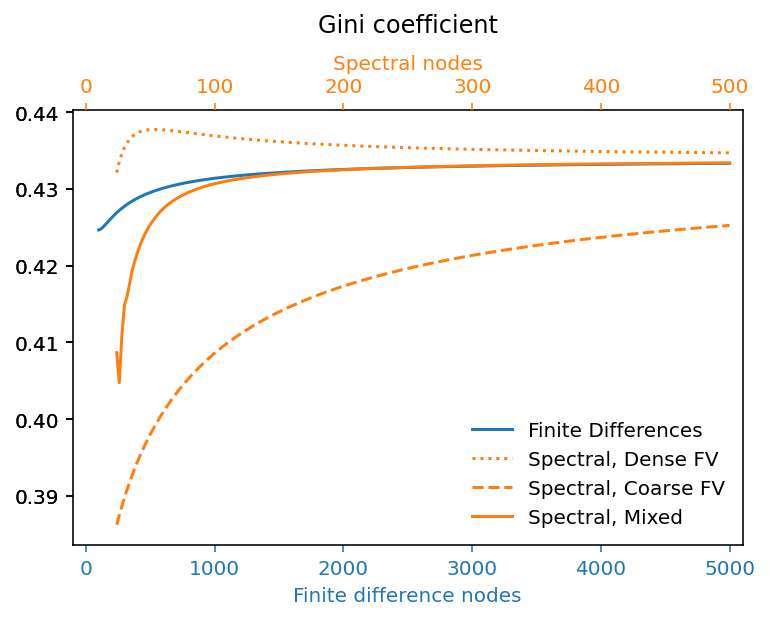

Saved to: two_state_benchmark_errors_gini.pdf


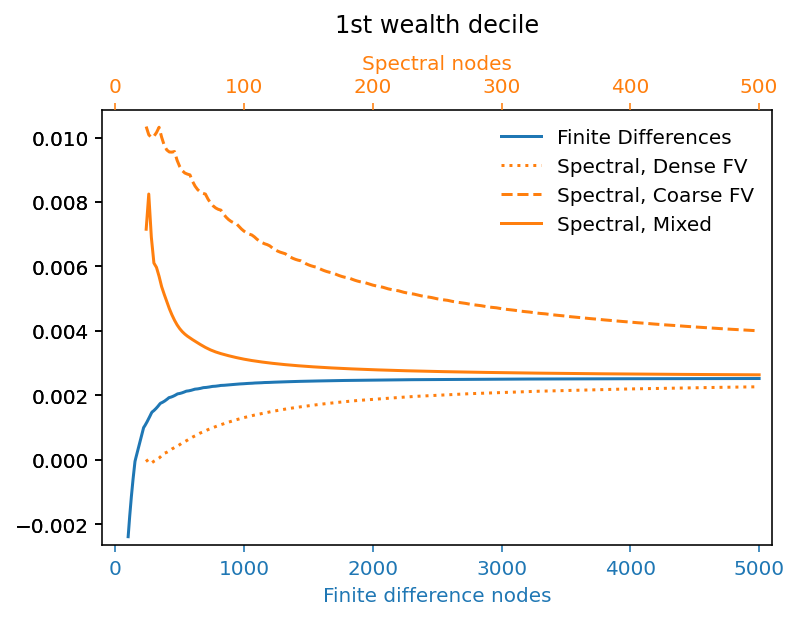

Saved to: two_state_benchmark_errors_D1.pdf


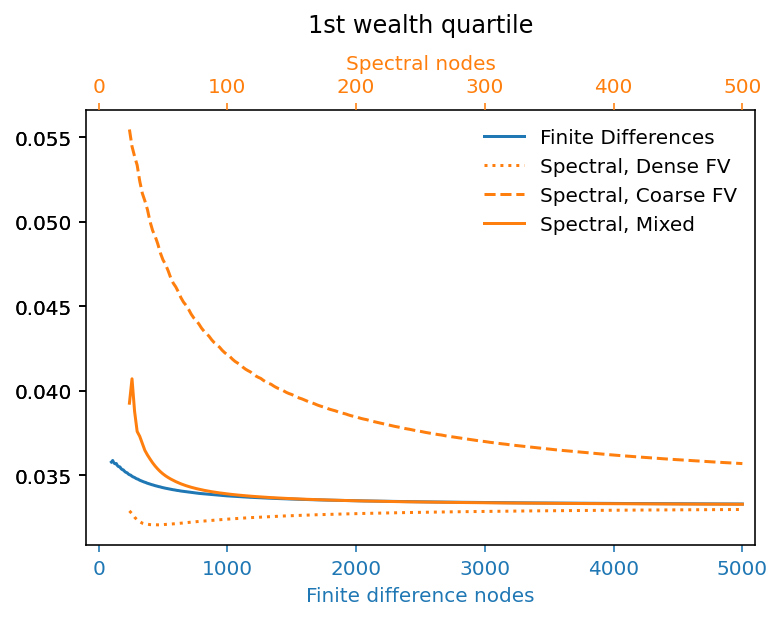

Saved to: two_state_benchmark_errors_Q1.pdf


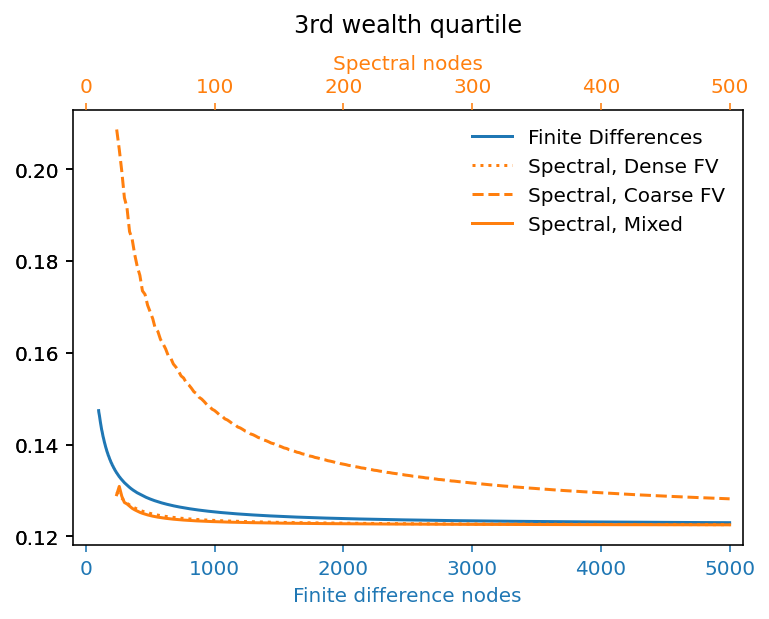

Saved to: two_state_benchmark_errors_Q3.pdf


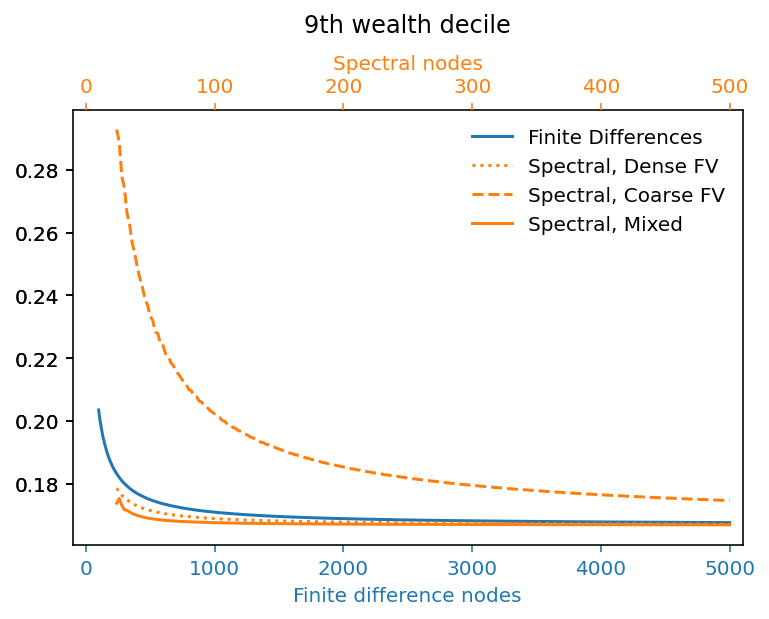

Saved to: two_state_benchmark_errors_D9.pdf


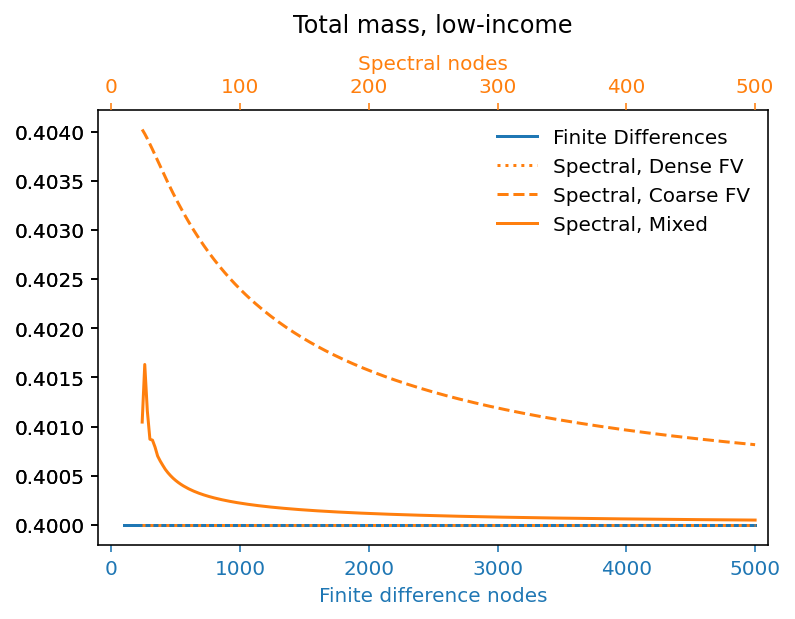

Saved to: two_state_benchmark_errors_total_mass_low.pdf


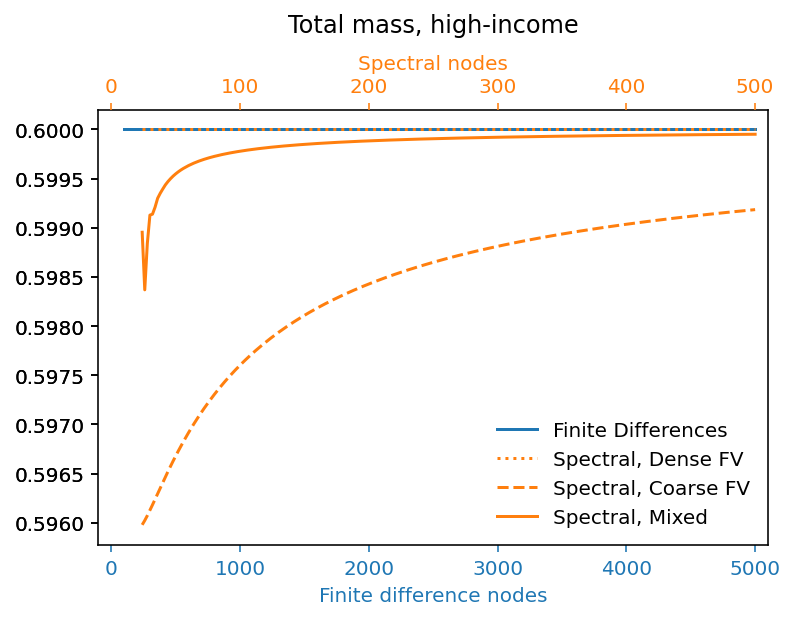

Saved to: two_state_benchmark_errors_total_mass_high.pdf


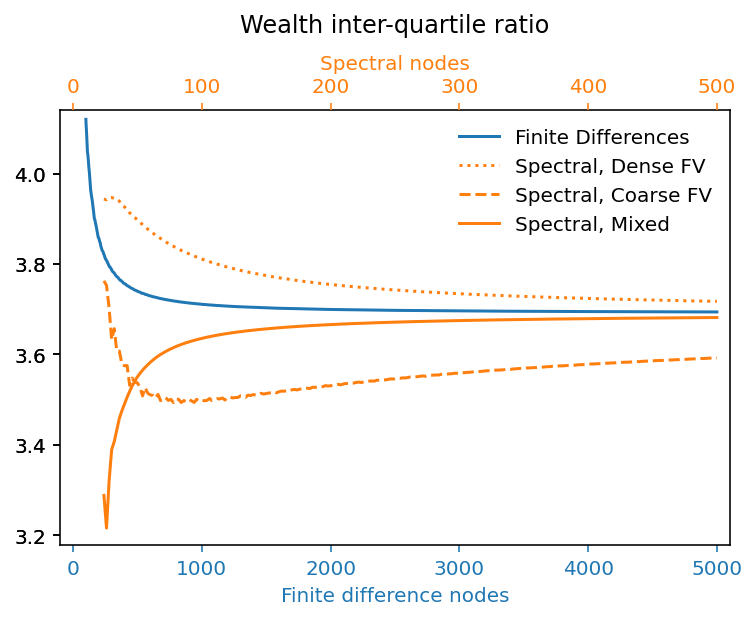

Saved to: two_state_benchmark_errors_IQR.pdf


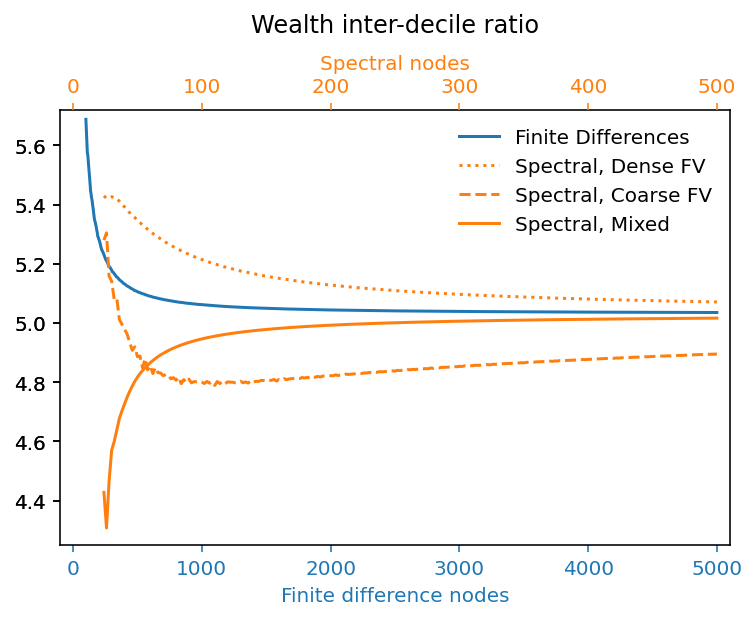

Saved to: two_state_benchmark_errors_IDR.pdf


In [ ]:
for moment in moments+computed_moments:
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(Is, fd_moments[moment], label='Finite Differences')
    ax2 = fig.add_subplot(111, label="2", frame_on=False)
    ax2.plot(Ns, spectral_moments['fv_dense', moment], 'C1:', label='Spectral, Dense FV')
    ax2.plot(Ns, spectral_moments['fv_coarse', moment], 'C1--', label='Spectral, Coarse FV')
    ax2.plot(Ns, spectral_moments['hybrid', moment], 'C1', label='Spectral, Mixed')
    
    ax1.set_xlim([-100,5100])
    ax2.set_xlim([-10,510])
    
    ymin = np.minimum(ax1.get_ylim()[0],ax2.get_ylim()[0])
    ymax = np.maximum(ax1.get_ylim()[1],ax2.get_ylim()[1])
    ax1.set_ylim([ymin,ymax])
    ax2.set_ylim([ymin,ymax])
    
    ax1.set_xlabel('Finite difference nodes', color='C0') 
    ax1.tick_params(axis='x', colors='C0')
    
    ax2.xaxis.tick_top()
    ax2.set_xlabel('Spectral nodes', color='C1') 
    ax2.xaxis.set_label_position('top')
    ax2.tick_params(axis='x', colors='C1')
    
    handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
    ax2.legend(handles, labels, frameon=False, loc='best')
    
    ax1.set_title(prettymoments[moment], y=1.15)

    savefig(ax1, 'two_state_benchmark_errors_'+moment)

### Errors vs Execution Time

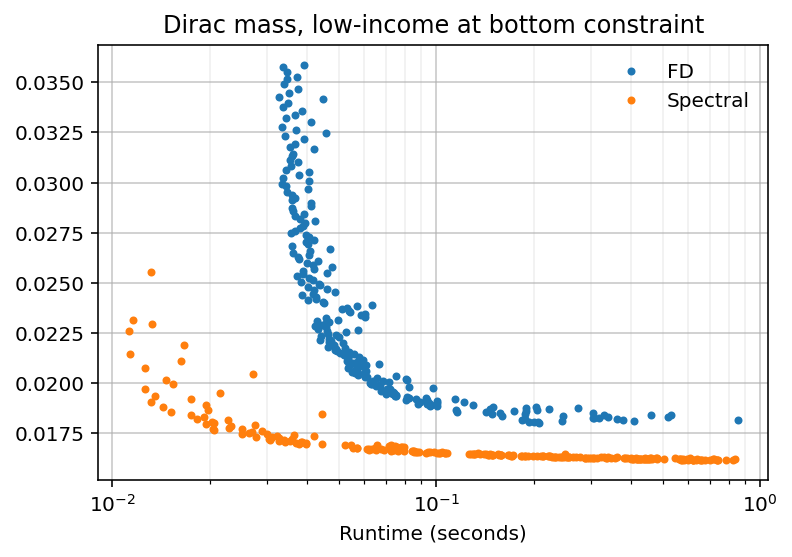

Saved to: two_state_benchmark_errors_dirac_mass_low_vs_time.pdf


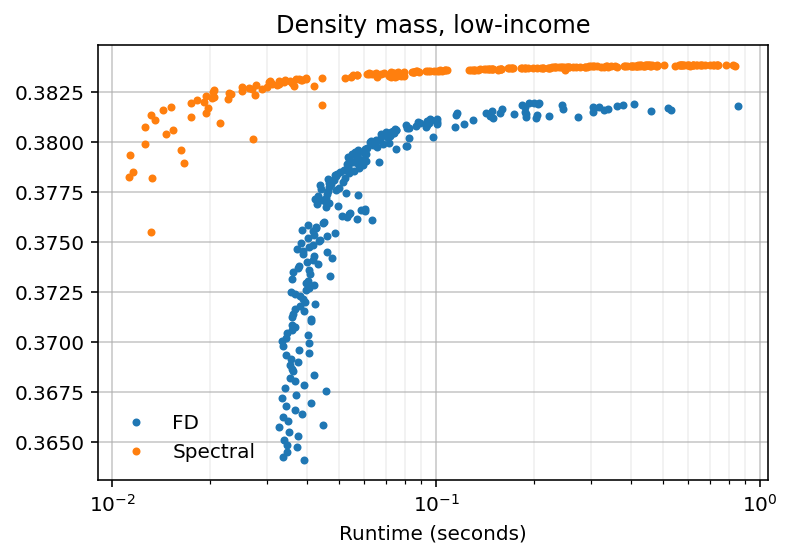

Saved to: two_state_benchmark_errors_density_mass_low_vs_time.pdf


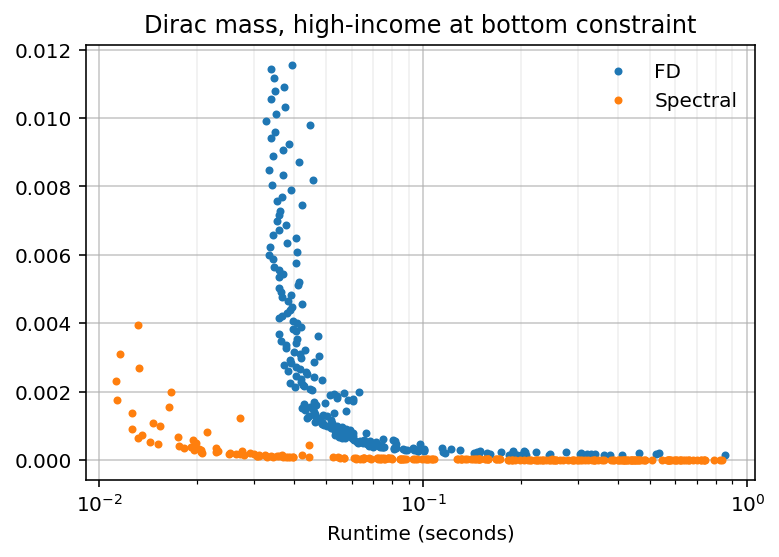

Saved to: two_state_benchmark_errors_dirac_mass_high_vs_time.pdf


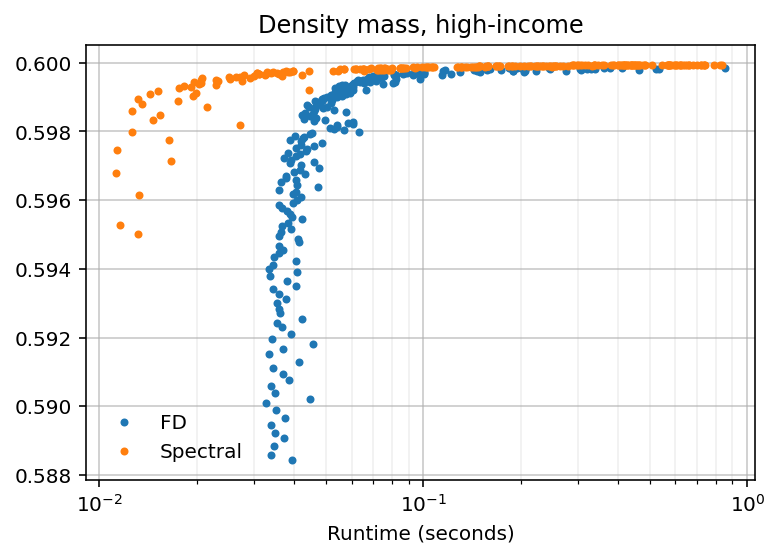

Saved to: two_state_benchmark_errors_density_mass_high_vs_time.pdf


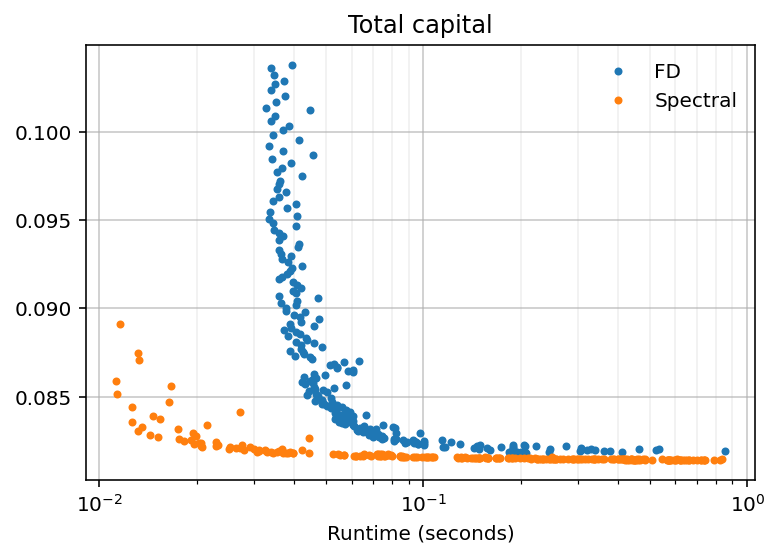

Saved to: two_state_benchmark_errors_K_vs_time.pdf


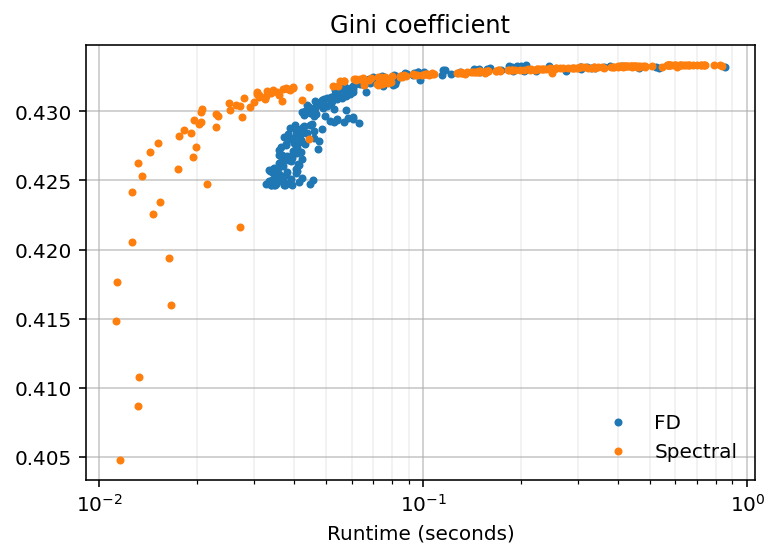

Saved to: two_state_benchmark_errors_gini_vs_time.pdf


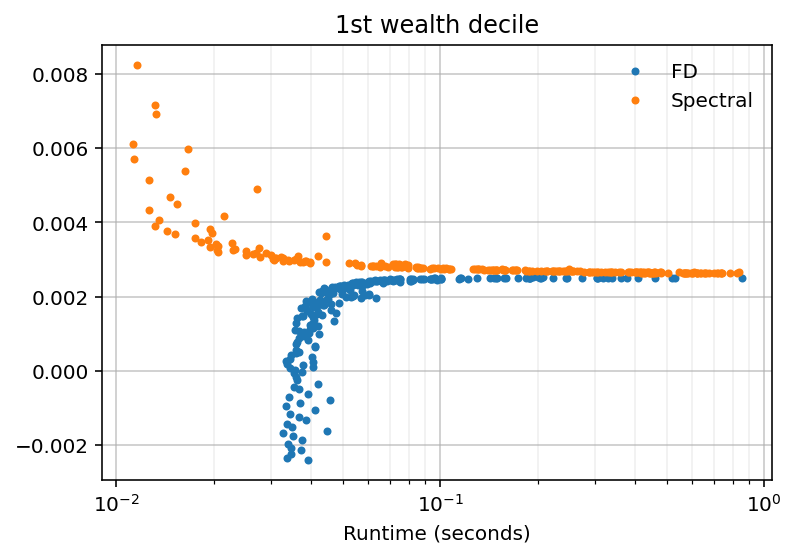

Saved to: two_state_benchmark_errors_D1_vs_time.pdf


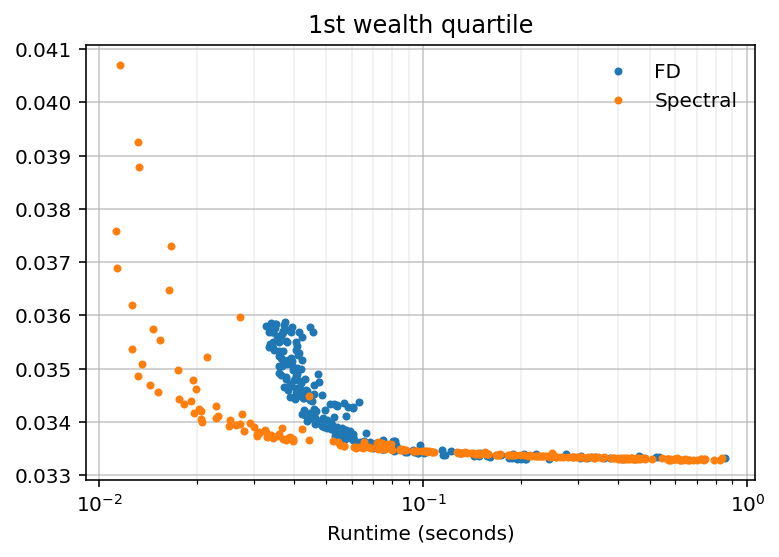

Saved to: two_state_benchmark_errors_Q1_vs_time.pdf


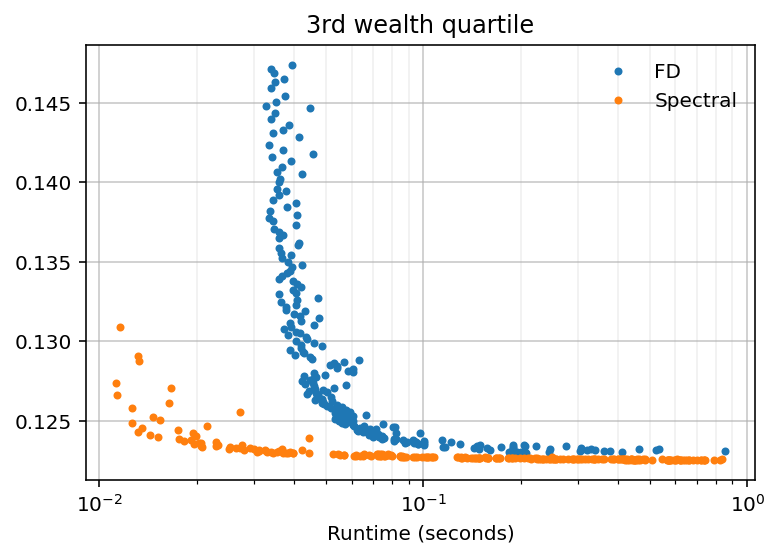

Saved to: two_state_benchmark_errors_Q3_vs_time.pdf


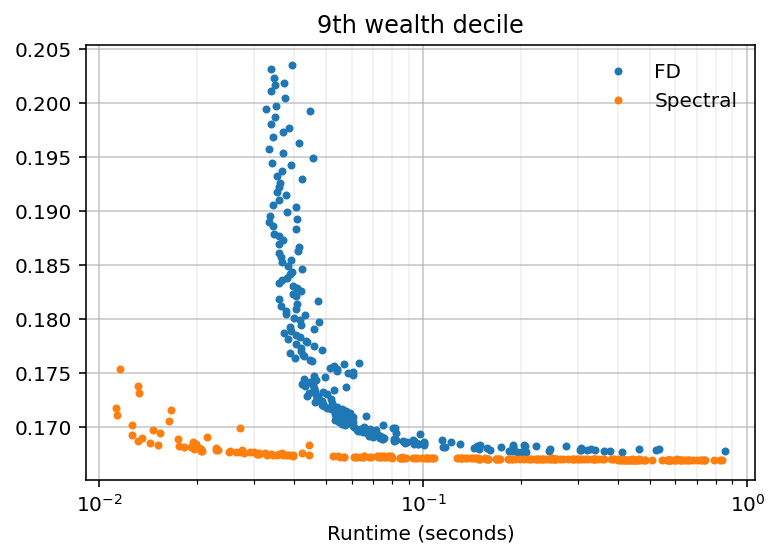

Saved to: two_state_benchmark_errors_D9_vs_time.pdf


In [ ]:
for moment in moments:
    fig, ax = plt.subplots(figsize=(6,4))
    plt.plot(fd_moments['time_total'], fd_moments[moment], '.', label='FD')
    plt.plot(spectral_moments['hybrid','time_total'], spectral_moments['hybrid',moment], '.', label='Spectral')
    plt.xscale('log')
    plt.grid(which='minor', alpha=0.2)
    plt.grid(which='major', alpha=0.7)
    plt.xlabel('Runtime (seconds)')
    plt.legend(frameon=False)
    plt.title(prettymoments[moment])
    savefig(ax, 'two_state_benchmark_errors_'+moment+'_vs_time')

